In [243]:
import glob
import pandas as pd
import numpy
import os
import time
import pickle
from collections import namedtuple, defaultdict
import seaborn as sb

from fnmatch import fnmatch
from sklearn import tree
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.ensemble import RandomForestClassifier
# TODO: Import xgboost-gpu and use it
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 

Results = namedtuple('Results', 'model precision recall f1 c_mat y_pred_test y_test total_time')

global_data_files = glob.glob('data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/*.csv')
df = pd.read_csv(global_data_files[0], index_col=0)

odour_features = [
    f for f in df.columns
    if fnmatch(f, '*Odour*')
]

prob_features = [
    f for f in df.columns
    if fnmatch(f, '*prob*')
]

non_odour_non_prob_features = sorted(set(df.columns) - set(odour_features + prob_features))
print(len(df.columns), len(odour_features), len(prob_features))

global_y_features = [f'Odour{i}' for i in range(1,7)]
distance_features = [f'{y_feature}_Animal_1_distance' for y_feature in global_y_features]


# Y funcs
def Y_combine_odours(_df):
    odour1 = _df['Odour1'] * 1
    odour2 = _df['Odour2'] * 1 #2
    odour3 = _df['Odour3'] * 1 #3
    odour4 = _df['Odour4'] * 1 #4
    odour5 = _df['Odour5'] * 1 #5
    odour6 = _df['Odour6'] * 1 #6

    assert not any((odour1 > 0) & (odour2 > 0) & (odour3 > 0) & (odour4 > 0) & (odour5 > 0) & (odour6 > 0))
    
    combined = odour1 + odour2 + odour3 + odour4 + odour5 + odour6
    combined_df = pd.DataFrame(combined, columns=['combined_odours'])
    return [combined_df]

def Y_all_odours(_df):
    return [_df[y_feature] for y_feature in global_y_features]

# X funcs
def X_only_builtins(_df):
    return [_df[non_odour_non_prob_features]]

def X_pre_animal_distance_only(_df):
    return [_df[x_feature] for x_feature in distance_features]

def X_builtins_and_distance(_df):
    return [_df[non_odour_non_prob_features + [x_feature]] for x_feature in distance_features]

# TODO: Cross validation would be one video file against the rest.  To expensive for now.
class Dataset(object):
    def __init__(self, x_func, y_func):
        # TODO: Include under and over sampling args, those must also be put into the keys etc.
        training_paths, testing_paths = self.init_data()
        self._training_paths = training_paths
        self._testing_paths = testing_paths
        self._orig_train_df = pd.concat([pd.read_csv(f, index_col=0) for f in self._training_paths])
        self._orig_test_df = pd.concat([pd.read_csv(f, index_col=0) for f in self._testing_paths])
        # x_func and y_func are used to extract the features and targets from the dataframes
        self.x_func = x_func
        self.y_func = y_func
        
        self.x_train_dfs = self.get_dfs('x', 'train')
        self.y_train_dfs = self.get_dfs('y', 'train')
        self.x_test_dfs = self.get_dfs('x', 'test')
        self.y_test_dfs = self.get_dfs('y', 'test')
        
    # TODO: under/over sampling!!
    def get_dfs(self, x_or_y=None, type_dataset=None):
        assert x_or_y in {'x', 'y'}
        assert type_dataset in {'train', 'test'}
        funcs = {'x': self.x_func, 'y': self.y_func}
        _df = {'train': self._orig_train_df, 'test': self._orig_test_df}
        
        # call the func on the dataframe
        _dfs = funcs[x_or_y](_df[type_dataset])
        
        assert isinstance(_dfs, list)
        assert all(isinstance(__df, (pd.DataFrame, pd.Series)) for __df in _dfs), f'Failed with types: {[type(__df) for __df in _dfs]}'
        return _dfs # list of dataframes with features or targets
        

    def init_data(self):
        raise NotImplemented('You must override init_data')
    
    def __iter__(self):
        x_len = len(self.x_train_dfs)
        y_len = len(self.y_train_dfs)

        print('x_len:', x_len, 'y_len:', y_len)

        from itertools import cycle
        for x_train, y_train, x_test, y_test in zip(
                cycle(self.x_train_dfs), self.y_train_dfs,
                cycle(self.x_test_dfs),  self.y_test_dfs
            ):
            yield x_train, y_train, x_test, y_test
            
    def cross_validation(self):
        raise NotImplemented('TODO: Implement 1 vs the rest CV')
        
    def __str__(self):
        train_path_str = '\n\t'.join(self._training_paths)
        test_path_str = '\n\t'.join(self._testing_paths)
        return f'{self.__class__.__name__}: x_func: {self.x_func.__name__}; y_func: {self.y_func.__name__}\n' \
               f'Training paths: {train_path_str}\n' \
               f'Testing paths: {test_path_str}\n'
    
    def key(self):
        """ For aggregating experiments and taking averages """
        return frozenset({
            ('x_func', self.x_func.__name__),
            ('y_func', self.y_func.__name__),
            ('_training_paths', self._training_paths),
            ('_testing_paths', self._testing_paths),
        })
        
        
# Data to load classes        
class ProtoDataset(Dataset):
    def init_data(self):
        data_files = glob.glob('data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/*.csv')
        training_paths = [data_files[0]]
        testing_paths = [data_files[1]]
        return training_paths, testing_paths
        
class FullDataset(Dataset):
    def init_data(self):
        data_files = glob.glob('data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/*.csv')
        _testing_idx = 1
        testing_paths = [data_files[i]]
        data_fi
        training_paths = data_files[1:]
        return training_paths, testing_paths


class Experiment(object):
    def __init__(self, dataset, model_type, model_kwargs):
        self.started_running = False
        self.finished_running = False
        self.dataset = dataset
        self.model_type = model_type
        self.model_kwargs = model_kwargs
        print(self)
    
    def run(self):
        self.started_running = True
        self.finished_running = False
        self.results = []
        first_run = True
        for x_train, y_train, x_test, y_test in self.dataset:
            start = time.time()
            if first_run:
                print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
                first_run = False
            model = self.model_type(**self.model_kwargs).fit(x_train, numpy.ravel(y_train))
            y_pred_test = model.predict(x_test)
            end = time.time()
            total_time = end - start
            
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='macro')
            c_mat = confusion_matrix(y_test, y_pred_test)
            
            self.results.append( Results(model, precision, recall, f1, c_mat, y_pred_test, y_test, total_time) )
            print('\n---- start results ----')
            print('run time:', total_time)
            print('recall', recall)
            print('macro f1:', f1)
            print(c_mat)
            print('---- end results ----\n')
            
        self.finished_running = True
    
    def explain(self):
        for res in self.results:
            print('\n---- start results ----')
            print('run time:', res.total_time)
            print('recall:', res.recall)
            print('macro f1:', res.f1)
            print(res.c_mat)
            print('---- end results ----\n')
    
    def __str__(self):
        return f'{self.__class__.__name__}: ' \
                f'\n\tDataset: {self.dataset};' \
                f'\n\tModel Type: {self.model_type};' \
                f'\n\tModel args: {self.model_kwargs}'
    def __repr__(self):
        return self.__str__()
    
    def save_state(self):
        raise NotImplemented('TODO: pickle with dill')
        
    def load_state(self):
        raise NotImplemented('TODO: load with dill')

    # TODO: define and produce the analysis stats afterwards


class ExperimentExpander(object):
    pass # TODO: Take a model type, set of arg dicts, and set of datasets, and expand the product of the exps

class ResultsAggregator(object):
    pass # TODO: Aggregate experiments and produce a report
# TODO: Or maybe we should make it a function 


281 36 7


In [235]:
def summary_df(e, with_args=True):
    """ Return a dataframe summary of an experiment.  Can be joined with other summary dataframes later """
    # The results of each experiment are a list of tuples.
    # model, f1_results, c_mat, total_time
    
    args = e.model_kwargs
    print(args)
    num_targets = len(e.results) # Hacky.  Should be writing down the 'class' we are targetting in each
    if num_targets == 0:
        targets = [0]
    else:
        targets = range(1, num_targets+1)
    res = defaultdict(list)
    for target_class, r in zip(targets, e.results):
        res['model type'].append(e.model_type.__name__)
        res['x_func'].append(e.dataset.x_func.__name__)
        res['y_func'].append(e.dataset.y_func.__name__)
        if with_args:
            for k,v in args.items():
                if k == 'num_parallel_tree':
                    k = 'n_estimators'
                res[k].append(v)
            if 'n_estimators' not in res:
                res['n_estimators'] = 1
        res['target_class'].append(target_class)
        res['macro_f1'].append(r.f1)
        res['recall'].append(r.recall)
        # precision: We don't care nearly as much here, because these will be filtered through a Klien filter later.
        res['run_time'].append(r.total_time)
    return pd.DataFrame.from_dict(res)
    
    
def combined_summary(*dfs):
    df_all = pd.concat([_df for _df in dfs])
    ## TODO: Really I want a pivot table with the same experiment setup as a value for a row, and the difference between
    ##       f1_scores, run_times, etc, which turns into a matrix for n-models... but we can do a direct comparison
    ##       rather easily.
    df_all = df_all.sort_values(by=['target_class', 'model type', 'x_func'])
#     df_all.style.background_gradient(cmap='Greens') # This was supposed to color the entries of the df when
#     displayed, but that didn't work out.
    return df_all

def create_heatmap(_df, values, title):
    cmap = sb.cubehelix_palette(start=2, rot=0, dark=0, light=.95, as_cmap=True)
    sb.heatmap(
        _df.pivot('target_class', ['model type', 'x_func'], values=values), annot=True, cmap=cmap
    ).set_title(title)

df = combined_summary(
    summary_df(exp3),
    summary_df(exp4),
    summary_df(exp_xgb_builtin_and_dist),
)

df
df.pivot_table(index=['model type', 'n_estimators'], values='run_time', aggfunc=[numpy.mean, len])

{'criterion': 'entropy', 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'n_estimators': 2000, 'n_jobs': 14}
{'n_jobs': 14, 'max_depth': 6, 'use_label_encoder': False, 'objective': 'binary:logistic', 'max_delta_step': 2, 'subsample': 0.75}
{'n_jobs': 14, 'max_depth': 6, 'use_label_encoder': False, 'objective': 'binary:logistic', 'max_delta_step': 2, 'subsample': 0.75}


mean      len
                                       run_time run_time
model type             n_estimators                     
RandomForestClassifier 2000          193.752349        6
XGBClassifier          1              46.585735       12

In [244]:
os.path.basename(exp1.dataset._testing_paths[0])

'10-13-2021_Rat11A_DOT.csv'

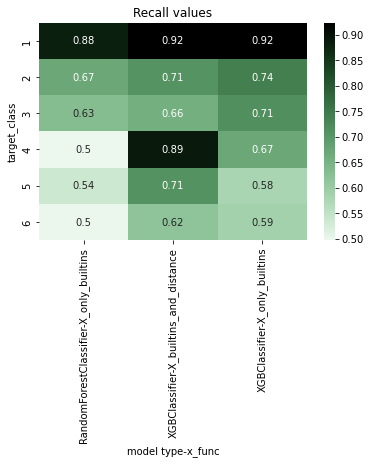

In [236]:
create_heatmap(df, 'recall', 'Recall values')

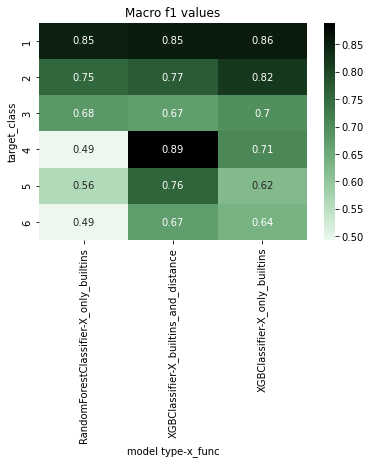

In [237]:
create_heatmap(df, 'macro_f1', 'Macro f1 values')

In [205]:
help(df.pivot)

Help on method pivot in module pandas.core.frame:

pivot(index=None, columns=None, values=None) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Return reshaped DataFrame organized by given index / column values.
    
    Reshape data (produce a "pivot" table) based on column values. Uses
    unique values from specified `index` / `columns` to form axes of the
    resulting DataFrame. This function does not support data
    aggregation, multiple values will result in a MultiIndex in the
    columns. See the :ref:`User Guide <reshaping>` for more on reshaping.
    
    Parameters
    ----------
    index : str or object or a list of str, optional
        Column to use to make new frame's index. If None, uses
        existing index.
    
        .. versionchanged:: 1.1.0
           Also accept list of index names.
    
    columns : str or object or a list of str
        Column to use to make new frame's columns.
    
        .. versionchanged:: 1.1.0
           Also acc

In [181]:
dt_kwargs = dict(
    criterion='entropy', # Gini is standard, shouldn't be a huge factor
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=15, # LIMIT MAX DEPTH!!  Runtime AND generalization error should improve drastically
#     ccp_alpha=0.005, # NEW PARAMETER, I NEED TO DEFINE MY EXPERIMENT SETUPS BETTER, AND STORE SOME RESULTS!!
    # Probably need to whip up a database again, that's the only way I have been able to navigate this in the past
    # Alternatively I could very carefully define my experiments, and then run them all in a batch and create a
    # meaningful report.  This is probably the best way to proceed.  It will lead to the most robust iteration
    # and progress.
)

rf_authors_kwargs = dict(
    criterion='entropy',
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=None,
    n_estimators=2000,
#     max_samples=0.5,
    n_jobs=14,
)

rf_our_kwargs = dict(
    **dt_kwargs,
    n_estimators=100, # default is 100
    n_jobs=14,
    max_samples=0.5,
)

xgb_kwargs = dict(
    n_jobs=14,
    max_depth=6, # default is 6
    use_label_encoder=False,
    objective='binary:logistic',
    max_delta_step=2, # Was set to 1
    subsample=0.75,
#     eval_metric='aucpr', # eval_metric='error' # Apparently aucpr was a noop... error is probably a noop as well.
    # eval_metric='error@t' # With 't' a different error threshold.
    
#     colsample_bytree=0.8,
#     num_parallel_tree=10,
)

In [182]:
dataset_type = FullDataset
# dataset_type = ProtoDataset

dataset_X_buitin_Y_separate = dataset_type(X_only_builtins, Y_all_odours)
dataset_X_buitin_Y_separate._orig_train_df.describe()

dataset_X_builtin_plus_distance_Y_separate = dataset_type(X_builtins_and_distance, Y_all_odours)
dataset_X_builtin_plus_distance_Y_separate._orig_train_df.describe()

Ear_left_x     Ear_left_y     Ear_left_p    Ear_right_x  \
count  171000.000000  171000.000000  171000.000000  171000.000000   
mean      474.311841     437.609332       0.957446     473.610223   
std       233.609185     232.244021       0.138743     232.836660   
min        69.013496      70.938469       0.006446      55.600956   
25%       219.121449     182.082092       0.989883     220.060459   
50%       501.766907     513.885986       0.997888     504.062592   
75%       704.259918     651.319458       0.999274     699.764664   
max       894.271912     834.440613       0.999982     885.989136   

         Ear_right_y    Ear_right_p         Nose_x         Nose_y  \
count  171000.000000  171000.000000  171000.000000  171000.000000   
mean      438.054215       0.966979     475.282356     436.598672   
std       233.165996       0.116279     232.121267     230.541625   
min        70.259537       0.003824      67.074371      45.707493   
25%       185.415550       0.992293     231.832947     194.887623   
50%       511.968323       0.998159     494.991089     507.001312   
75%       655.751587       0.999261     697.892975     645.658844   
max       826.905457       0.999957     898.175842     868.008972   

              Nose_p       Center_x  ...  \
count  171000.000000  171000.000000  ...   
mean        0.951413     476.688474  ...   
std         0.159212     236.205882  ...   
min         0.005823      80.870895  ...   
25%         0.993209     216.105774  ...   
50%         0.998884     520.728882  ...   
75%         0.999572     710.960495  ...   
max         0.999984     874.749756  ...   

       Odour2_Animal_1_in_zone_cumulative_time  \
count                            171000.000000   
mean                                  4.621539   
std                                   5.347152   
min                                   0.000000   
25%                                   0.000000   
50%                                   3.466667   
75%                                   7.766667   
max                                  26.500000   

       Odour2_Animal_1_in_zone_cumulative_percent  \
count                               171000.000000   
mean                                     0.001070   
std                                      0.001430   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000672   
75%                                      0.001647   
max                                      0.066667   

       Odour4_Animal_1_in_zone_cumulative_time  \
count                            171000.000000   
mean                                  6.289396   
std                                   8.507764   
min                                   0.000000   
25%                                   0.233333   
50%                                   4.766667   
75%                                   8.700000   
max                                  59.666667   

       Odour4_Animal_1_in_zone_cumulative_percent         Odour1  \
count                               171000.000000  171000.000000   
mean                                     0.001466       0.034187   
std                                      0.002175       0.181710   
min                                      0.000000       0.000000   
25%                                      0.000164       0.000000   
50%                                      0.000901       0.000000   
75%                                      0.001967       0.000000   
max                                      0.066667       1.000000   

              Odour2         Odour3         Odour4         Odour5  \
count  171000.000000  171000.000000  171000.000000  171000.000000   
mean        0.031012       0.027637       0.028789       0.024766   
std         0.173350       0.163932       0.167215       0.155412   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.00

In [183]:
exp_xgb_builtin_and_dist = Experiment(dataset_X_builtin_plus_distance_Y_separate, xgb.XGBClassifier, xgb_kwargs)
exp_xgb_builtin_and_dist.run()

# NOTE: FOR MORNING: I'm running an eval_metric experiment right now, 'aucpr' is this run, will also do 'error'

Experiment: 
	Dataset: FullDataset: x_func: X_builtins_and_distance; y_func: Y_all_odours
Training paths: data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-25-2021_Rat19A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat9A_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat13E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-03-2021_Rat13A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-13-2021_Rat6E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat14A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-14-2021_Rat2E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat3E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat13A_IOT.csv
	data/Ma

In [184]:
print('========= exp1 ============')
exp1 = Experiment(dataset_X_buitin_Y_separate, DTree, dt_kwargs)
exp1.run()
# exp1.explain()

========= exp1 ============
Experiment: 
	Dataset: FullDataset: x_func: X_only_builtins; y_func: Y_all_odours
Training paths: data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-25-2021_Rat19A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat9A_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat13E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-03-2021_Rat13A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-13-2021_Rat6E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat14A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-14-2021_Rat2E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat3E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat

In [185]:
print('========= exp2 ============')
exp2 = Experiment(dataset_X_buitin_Y_separate, RandomForestClassifier, rf_our_kwargs)
exp2.run()
# exp2.explain()

========= exp2 ============
Experiment: 
	Dataset: FullDataset: x_func: X_only_builtins; y_func: Y_all_odours
Training paths: data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-25-2021_Rat19A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat9A_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat13E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-03-2021_Rat13A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-13-2021_Rat6E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat14A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-14-2021_Rat2E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat3E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat

/home/aaron/anaconda3/envs/xgboost-cpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
print('========= exp3 ============')
exp3 = Experiment(dataset_X_buitin_Y_separate, RandomForestClassifier, rf_authors_kwargs)
exp3.run()
# exp3.explain()

========= exp3 ============
Experiment: 
	Dataset: FullDataset: x_func: X_only_builtins; y_func: Y_all_odours
Training paths: data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-25-2021_Rat19A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat9A_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat13E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-03-2021_Rat13A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-13-2021_Rat6E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat14A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-14-2021_Rat2E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat3E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat

In [187]:
print('========== exp4 =======')
exp4 = Experiment(dataset_X_buitin_Y_separate, xgb.XGBClassifier, xgb_kwargs)
exp4.run()

========== exp4 =======
Experiment: 
	Dataset: FullDataset: x_func: X_only_builtins; y_func: Y_all_odours
Training paths: data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-25-2021_Rat19A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat9A_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat13E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-03-2021_Rat13A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-13-2021_Rat6E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-11-2021_Rat14A_DOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-14-2021_Rat2E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat3E_IOT.csv
	data/May1-2022-odourspan-6-object-open-field/SimBA_NOD/targets_inserted/10-02-2021_Rat13A_

In [188]:
f1_matrices = [f1_result for _, _, f1_result, _ in exp4.results]
f1 = numpy.zeros_like(f1_matrices[0])
for mat in f1_matrices:
    f1 += mat
f1

ValueError: too many values to unpack (expected 4)

In [ ]:
f1_matrices_with_dist = [f1_result for _,_,f1_result, _ in exp_xgb_builtin_and_dist.results]

for i, (mat, mat_with_dist) in enumerate(zip(f1_matrices, f1_matrices_with_dist)):
    print(f'==== {i+1} ====')
    print(mat - mat_with_dist)
print('Depth limit of 2 as opposed to default of 6 and RF of size 10 showed improvement')

### Results with dist and subsample=0.75
==== 1 ====

[[ -4   4]

[-11  11]]

==== 2 ====

[[  3  -3]

[-29  29]]

==== 3 ====

[[-43  43]

[  3  -3]]

==== 4 ====

[[-16  16]

[ 89 -89]]

==== 5 ====

[[ 20 -20]

[ 49 -49]]

==== 6 ====

[[-16  16]

[ 31 -31]]

Performance improved in most cases by adding the distance feature

In [ ]:
dataset_combined_ys = FullDataset(X_only_builtins, Y_combine_odours)

In [ ]:
print('========= exp1 ==========')
exp1_combined = Experiment(dataset_combined_ys, DTree, dt_kwargs)
exp1_combined.run()

In [ ]:
print('========= exp2 ==========')
exp2_combined = Experiment(dataset_combined_ys, RandomForestClassifier, rf_our_kwargs)
exp2_combined.run()

In [ ]:
print('========= exp3 ==========')
exp3_combined = Experiment(dataset_combined_ys, RandomForestClassifier, rf_authors_kwargs)
exp3_combined.run()

In [ ]:

# xgb_kwargs = dict(
#     n_jobs=14,
# #     max_depth=3,
#     objective='binary:logistic',
#     max_delta_step=1,
#     subsample=0.75,
    
# #     colsample_bytree=0.8,
# #     num_parallel_tree=10,
# )

# NOTE: interaction_constraints could be used to specify interactions only between x's and y's of the same point...
#       Still not exactly what I am looking for

exp_xgboost = Experiment(dataset_combined_ys, xgb.XGBClassifier, xgb_kwargs)
exp_xgboost.run()

In [ ]:
import dill
outfile = 'temp.pkl'

with open(outfile, 'wb') as f:
    dill.dump(exp4, f)

In [11]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  P

Unnamed: 0   Ear_left_x   Ear_left_y   Ear_left_p  Ear_right_x  \
count  9000.000000  9000.000000  9000.000000  9000.000000  9000.000000   
mean   4499.500000   526.563981   362.474487     0.981355   523.231195   
std    2598.220545   178.713025   207.717119     0.080402   176.322678   
min       0.000000   146.763992    88.288025     0.021942   143.909363   
25%    2249.750000   385.850502   136.719418     0.995551   377.178665   
50%    4499.500000   574.617737   376.731262     0.998951   565.337647   
75%    6749.250000   683.516357   573.390747     0.999623   686.132965   
max    8999.000000   765.466858   698.248596     0.999974   756.227600   

       Ear_right_y  Ear_right_p       Nose_x       Nose_y       Nose_p  ...  \
count  9000.000000  9000.000000  9000.000000  9000.000000  9000.000000  ...   
mean    354.949515     0.982741   515.903257   360.921026     0.953568  ...   
std     209.746799     0.079101   178.544509   203.671132     0.153474  ...   
min      94.335625     0.040251   112.695808    73.188545     0.011809  ...   
25%     138.102097     0.996077   394.306244   161.027935     0.994984  ...   
50%     373.360428     0.998950   573.177918   384.308029     0.999118  ...   
75%     562.719635     0.999535   666.435440   570.250671     0.999653  ...   
max     691.946960     0.999952   774.226746   704.357483     0.999981  ...   

       Odour5_Animal_1_in_zone_cumulative_time  \
count                              9000.000000   
mean                                  6.066070   
std                                   1.799801   
min                                   0.000000   
25%                                   5.333333   
50%                                   5.333333   
75%                                   7.266667   
max                                   8.266667   

       Odour5_Animal_1_in_zone_cumulative_percent  \
count                                 9000.000000   
mean                                     0.001891   
std                                      0.001541   
min                                      0.000000   
25%                                      0.001063   
50%                                      0.001271   
75%                                      0.002054   
max                                      0.008766   

       Odour2_Animal_1_in_zone_cumulative_time  \
count                              9000.000000   
mean                                  0.418052   
std                                   0.155545   
min                                   0.000000   
25%                                   0.400000   
50%                                   0.400000   
75%                                   0.400000   
max                                   1.566667   

       Odour2_Animal_1_in_zone_cumulative_percent       Odour1       Odour2  \
count                                 9000.000000  9000.000000  9000.000000   
mean                                     0.000170     0.018000     0.018111   
std                                      0.000231     0.132959     0.133361   
min                                      0.000000     0.000000     0.000000   
25%                                      0.000062     0.000000     0.000000   
50%                                      0.000088     0.000000     0.000000   
75%                                      0.000170     0.000000     0.000000   
max                                      0.001843     1.000000     1.000000   

            Odour3       Odour4       Odour5       Odour6  
count  9000.000000  9000.000000  9000.000000  9000.000000  
mean      0.017333     0.023778     0.029778     0.028000  
std       0.130517     0.152365     0.169983     0.164982  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000

Unnamed: 0 0          0
1          1
2          2
3          3
4          4
        ... 
8995    8995
8996    8996
8997    8997
8998    8998
8999    8999
Name: Unnamed: 0, Length: 9000, dtype: int64


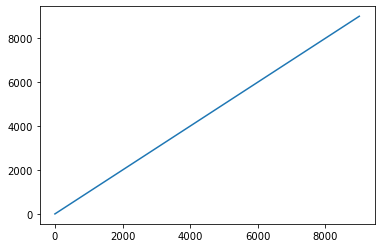

Ear_left_x 0       725.815735
1       726.061401
2       726.061401
3       725.815735
4       721.106079
           ...    
8995    587.235107
8996    587.235107
8997    587.156067
8998    586.917969
8999    586.917969
Name: Ear_left_x, Length: 9000, dtype: float64


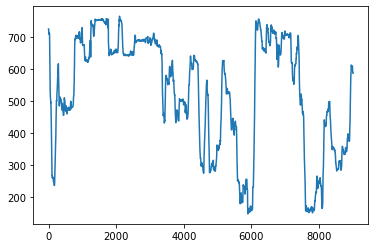

Ear_left_y 0       320.062134
1       330.124268
2       351.426514
3       358.920471
4       374.436737
           ...    
8995    167.545197
8996    167.545197
8997    167.545197
8998    167.083298
8999    167.052231
Name: Ear_left_y, Length: 9000, dtype: float64


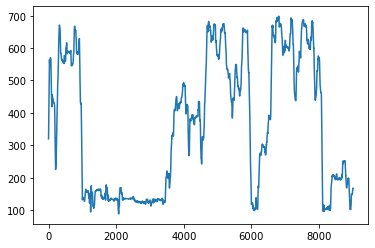

Ear_left_p 0       0.997651
1       0.996874
2       0.998930
3       0.999804
4       0.999766
          ...   
8995    0.998319
8996    0.998188
8997    0.998188
8998    0.998904
8999    0.998721
Name: Ear_left_p, Length: 9000, dtype: float64


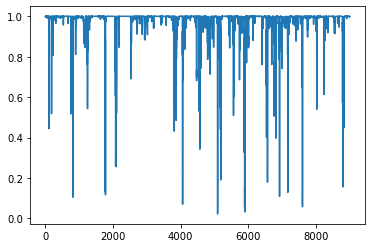

Ear_right_x 0       698.643372
1       699.236938
2       699.236938
3       699.236938
4       696.033691
           ...    
8995    563.500793
8996    563.291992
8997    562.770264
8998    562.517456
8999    562.279724
Name: Ear_right_x, Length: 9000, dtype: float64


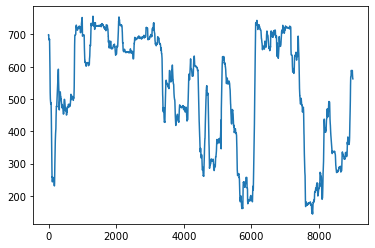

Ear_right_y 0       320.803619
1       327.350464
2       342.983520
3       352.203308
4       364.348389
           ...    
8995    163.747513
8996    163.747513
8997    163.747513
8998    163.522827
8999    163.415619
Name: Ear_right_y, Length: 9000, dtype: float64


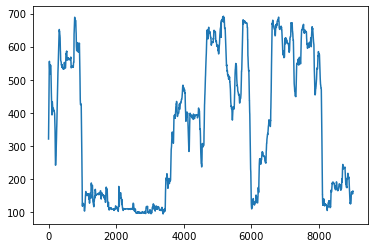

Ear_right_p 0       0.991558
1       0.999013
2       0.998156
3       0.997254
4       0.998820
          ...   
8995    0.999726
8996    0.999742
8997    0.999726
8998    0.999736
8999    0.999714
Name: Ear_right_p, Length: 9000, dtype: float64


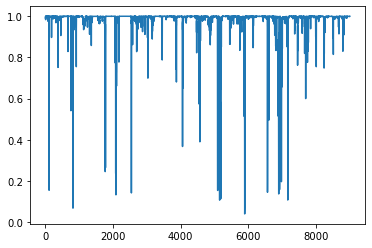

Nose_x 0       703.026062
1       703.026062
2       703.026062
3       702.778870
4       698.368347
           ...    
8995    565.625183
8996    565.701355
8997    565.829285
8998    565.829285
8999    565.525330
Name: Nose_x, Length: 9000, dtype: float64


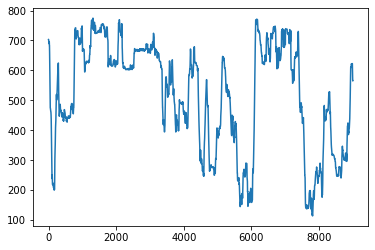

Nose_y 0       355.571106
1       367.096100
2       381.528015
3       386.865417
4       401.206787
           ...    
8995    203.012604
8996    203.808304
8997    203.808304
8998    203.808304
8999    202.987823
Name: Nose_y, Length: 9000, dtype: float64


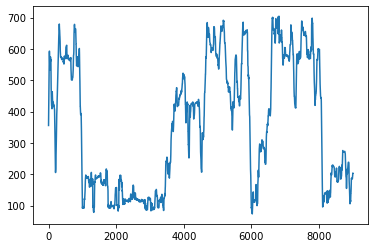

Nose_p 0       0.999889
1       0.999740
2       0.999731
3       0.999539
4       0.999208
          ...   
8995    0.999765
8996    0.999787
8997    0.999808
8998    0.999796
8999    0.999762
Name: Nose_p, Length: 9000, dtype: float64


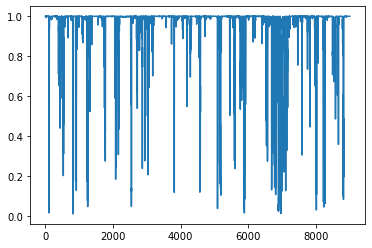

Center_x 0       690.516296
1       694.606934
2       700.678162
3       702.529419
4       702.711975
           ...    
8995    554.793579
8996    554.423706
8997    554.423706
8998    554.197632
8999    554.197632
Name: Center_x, Length: 9000, dtype: float64


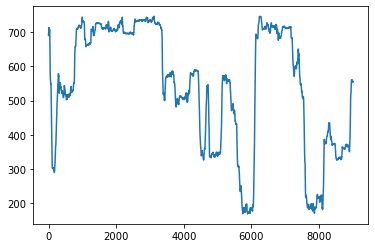

Center_y 0       284.558136
1       289.783539
2       301.765320
3       306.893829
4       315.990051
           ...    
8995    125.746445
8996    125.746445
8997    125.746445
8998    125.597961
8999    125.554550
Name: Center_y, Length: 9000, dtype: float64


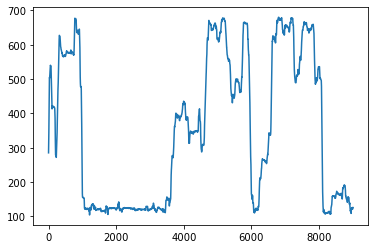

Center_p 0       0.997446
1       0.999117
2       0.999190
3       0.998123
4       0.997371
          ...   
8995    0.996644
8996    0.997348
8997    0.996370
8998    0.996448
8999    0.996947
Name: Center_p, Length: 9000, dtype: float64


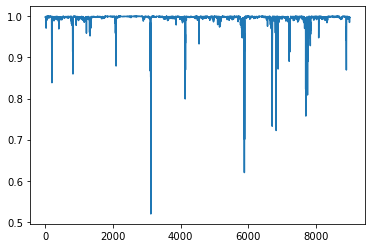

Lat_left_x 0       660.573608
1       670.800720
2       678.960388
3       684.100464
4       685.578735
           ...    
8995    530.522461
8996    530.345032
8997    530.224731
8998    530.094177
8999    529.628784
Name: Lat_left_x, Length: 9000, dtype: float64


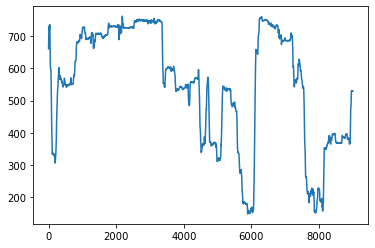

Lat_left_y 0       261.993378
1       263.029633
2       265.313721
3       267.621521
4       269.199707
           ...    
8995     99.541611
8996     99.407028
8997     99.352341
8998     98.402245
8999     98.268898
Name: Lat_left_y, Length: 9000, dtype: float64


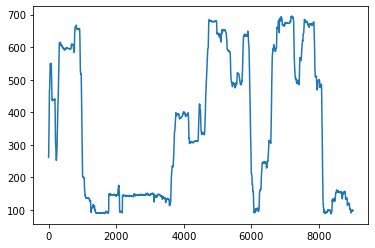

Lat_left_p 0       0.997182
1       0.993212
2       0.998245
3       0.993408
4       0.995286
          ...   
8995    0.996753
8996    0.996235
8997    0.995106
8998    0.995461
8999    0.995918
Name: Lat_left_p, Length: 9000, dtype: float64


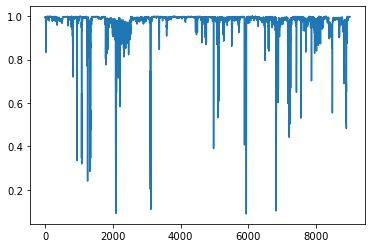

Lat_right_x 0       665.011719
1       665.277893
2       666.080261
3       666.080261
4       665.011719
           ...    
8995    518.916199
8996    518.901916
8997    518.901916
8998    518.901916
8999    518.671875
Name: Lat_right_x, Length: 9000, dtype: float64


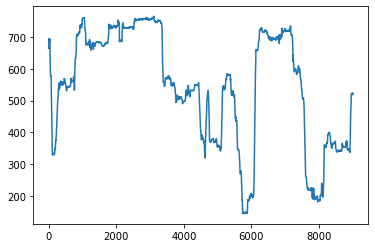

Lat_right_y 0       302.587891
1       303.030609
2       305.447601
3       307.909912
4       311.520264
           ...    
8995    132.873612
8996    133.432556
8997    133.432556
8998    133.432556
8999    132.564423
Name: Lat_right_y, Length: 9000, dtype: float64


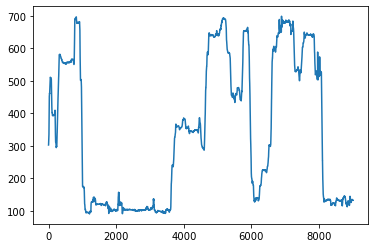

Lat_right_p 0       0.986194
1       0.990217
2       0.993962
3       0.993766
4       0.995353
          ...   
8995    0.981690
8996    0.980191
8997    0.974707
8998    0.971729
8999    0.976428
Name: Lat_right_p, Length: 9000, dtype: float64


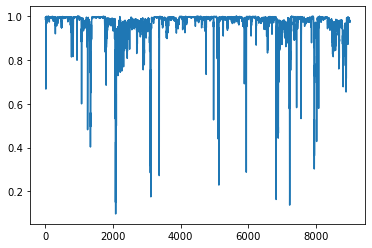

Tail_base_x 0       627.851440
1       633.023377
2       633.149719
3       635.973389
4       636.315063
           ...    
8995    486.173706
8996    486.150482
8997    485.633789
8998    485.359772
8999    485.265137
Name: Tail_base_x, Length: 9000, dtype: float64


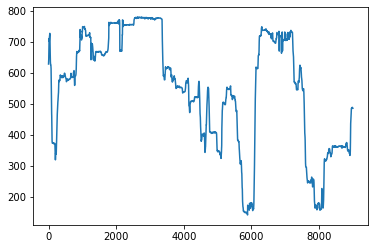

Tail_base_y 0       287.452332
1       287.996185
2       287.996185
3       287.452332
4       287.138886
           ...    
8995    113.428978
8996    113.537384
8997    113.537384
8998    113.537384
8999    113.386696
Name: Tail_base_y, Length: 9000, dtype: float64


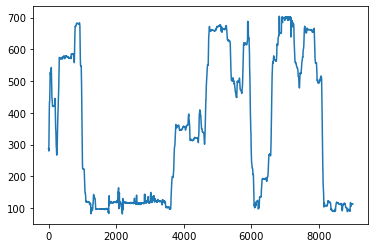

Tail_base_p 0       0.999779
1       0.998765
2       0.999004
3       0.999257
4       0.999299
          ...   
8995    0.999555
8996    0.999532
8997    0.999462
8998    0.999509
8999    0.999604
Name: Tail_base_p, Length: 9000, dtype: float64


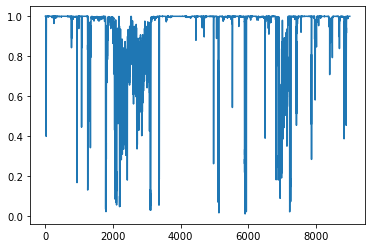

Tail_end_x 0       531.958679
1       535.805969
2       536.516113
3       537.994446
4       546.487549
           ...    
8995    372.750122
8996    372.466095
8997    372.466095
8998    372.234833
8999    372.158142
Name: Tail_end_x, Length: 9000, dtype: float64


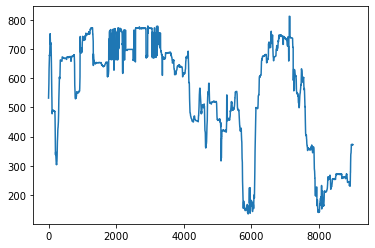

Tail_end_y 0       352.038971
1       352.322784
2       352.322784
3       352.038971
4       351.777008
           ...    
8995    145.366623
8996    145.546524
8997    145.546524
8998    145.546524
8999    143.681397
Name: Tail_end_y, Length: 9000, dtype: float64


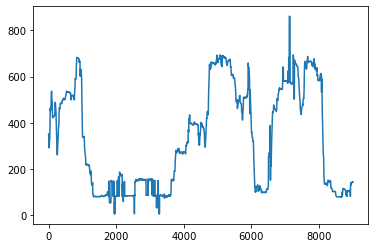

Tail_end_p 0       0.999600
1       0.999482
2       0.999104
3       0.999422
4       0.999134
          ...   
8995    0.999467
8996    0.999472
8997    0.999416
8998    0.999425
8999    0.999175
Name: Tail_end_p, Length: 9000, dtype: float64


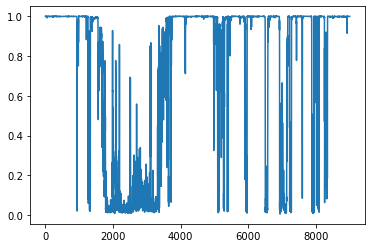

Mouse_poly_area 0       360.397855
1       372.001314
2       401.795542
3       407.674290
4       434.218603
           ...    
8995    391.745538
8996    393.524603
8997    394.567412
8998    396.116688
8999    394.614067
Name: Mouse_poly_area, Length: 9000, dtype: float64


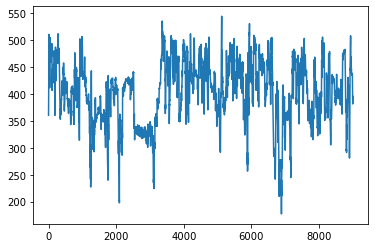

Mouse_nose_to_tail 0       134.091381
1       139.617833
2       154.321413
3       158.317249
4       171.640433
           ...    
8995    158.272158
8996    159.039797
8997    159.604420
8998    159.845202
8999    159.000686
Name: Mouse_nose_to_tail, Length: 9000, dtype: float64


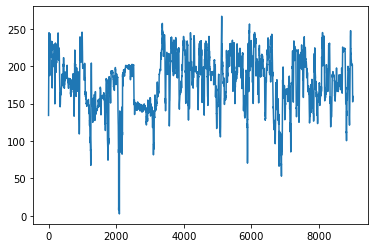

Mouse_width 0       53.977310
1       53.374626
2       55.713678
3       58.337144
4       62.195038
          ...    
8995    46.652547
8996    47.450043
8997    47.468188
8998    48.608778
8999    47.588937
Name: Mouse_width, Length: 9000, dtype: float64


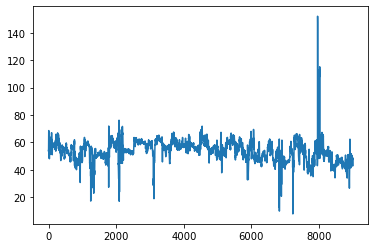

Mouse_Ear_distance 0       35.929640
1       35.645477
2       37.171238
3       36.236274
4       35.722679
          ...    
8995    31.770940
8996    32.043495
8997    32.621542
8998    32.594006
8999    32.919522
Name: Mouse_Ear_distance, Length: 9000, dtype: float64


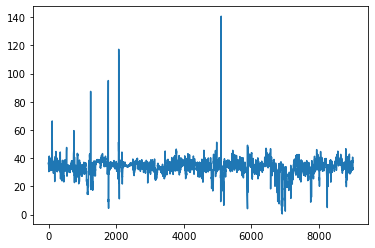

Mouse_Nose_to_centroid 0        95.309846
1       102.795428
2       105.475530
3       105.706491
4       112.785210
           ...    
8995    103.128603
8996    104.252940
8997    104.277252
8998    104.514999
8999    103.440239
Name: Mouse_Nose_to_centroid, Length: 9000, dtype: float64


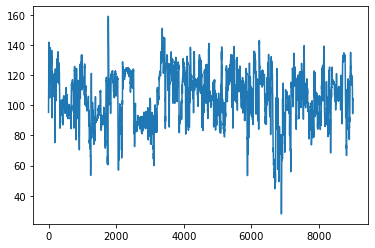

Mouse_Nose_to_lateral_left 0       135.823607
1       143.998550
2       156.870397
3       159.537813
4       175.303210
           ...    
8995    144.423461
8996    145.695630
8997    145.869625
8998    147.114175
8999    146.323359
Name: Mouse_Nose_to_lateral_left, Length: 9000, dtype: float64


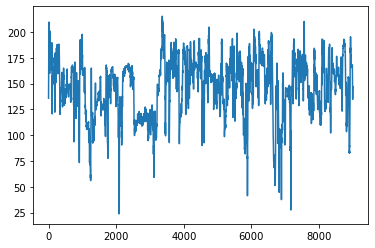

Mouse_Nose_to_lateral_right 0        86.193864
1        98.287739
2       111.793013
3       115.085388
4       126.480831
           ...    
8995    111.385824
8996    111.712590
8997    111.806313
8998    111.806313
8999    111.804577
Name: Mouse_Nose_to_lateral_right, Length: 9000, dtype: float64


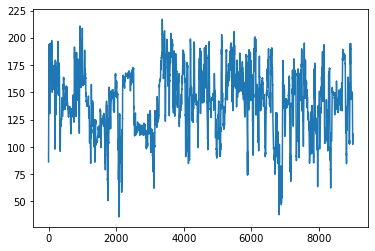

Mouse_Centroid_to_lateral_left 0       49.558166
1       47.336238
2       56.084907
3       57.341200
4       65.863083
          ...    
8995    47.211935
8996    47.170598
8997    47.331289
8998    48.033780
8999    48.532261
Name: Mouse_Centroid_to_lateral_left, Length: 9000, dtype: float64


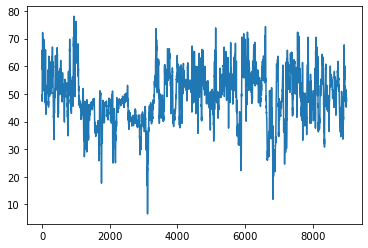

Mouse_Centroid_to_lateral_right 0       41.284765
1       42.537904
2       45.989583
3       48.196999
4       50.180994
          ...    
8995    48.349179
8996    48.039059
8997    48.039059
8998    47.789181
8999    47.863144
Name: Mouse_Centroid_to_lateral_right, Length: 9000, dtype: float64


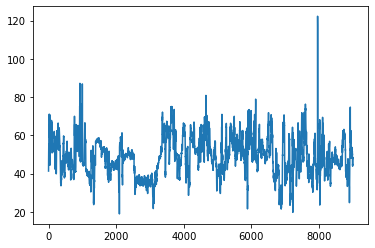

Movement_mouse_centroid 0       987.182983
1         8.771590
2        17.754549
3         7.206962
4        12.025754
           ...    
8995      0.898076
8996      0.488896
8997      0.000000
8998      0.357513
8999      0.057381
Name: Movement_mouse_centroid, Length: 9000, dtype: float64


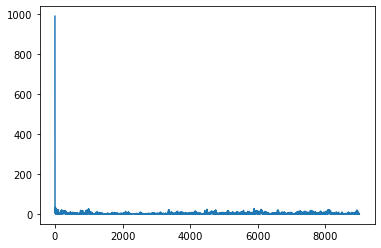

Movement_mouse_nose 0       1041.349366
1         15.233669
2         19.076021
3          7.062509
4         19.832533
           ...     
8995       3.082113
8996       1.056560
8997       0.169097
8998       0.000000
8999       1.156533
Name: Movement_mouse_nose, Length: 9000, dtype: float64


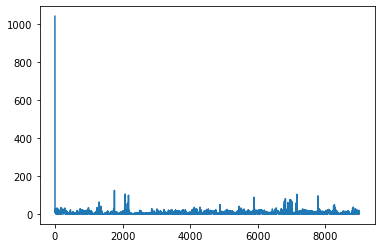

Movement_mouse_tail_base 0       912.733331
1         6.873927
2         0.166999
3         3.800908
4         0.612877
           ...    
8995      0.390229
8996      0.146542
8997      0.682962
8998      0.362195
8999      0.235200
Name: Movement_mouse_tail_base, Length: 9000, dtype: float64


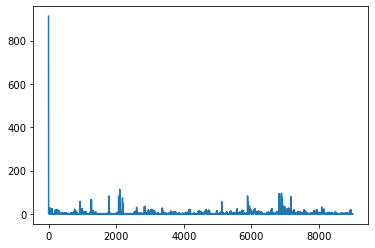

Movement_mouse_tail_end 0       843.167366
1         5.099144
2         0.938664
3         1.989736
4        11.231473
           ...    
8995      0.533920
8996      0.444398
8997      0.000000
8998      0.305681
8999      2.467398
Name: Movement_mouse_tail_end, Length: 9000, dtype: float64


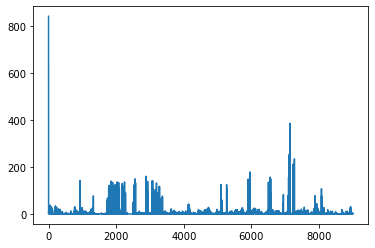

Movement_mouse_left_ear 0       1048.515439
1         13.304033
2         28.157184
3          9.910790
4         21.433264
           ...     
8995       2.287715
8996       0.000000
8997       0.104475
8998       0.686877
8999       0.041064
Name: Movement_mouse_left_ear, Length: 9000, dtype: float64


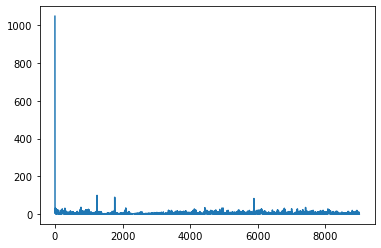

Movement_mouse_right_ear 0       1016.164456
1          8.689074
2         20.663683
3         12.186661
4         16.602270
           ...     
8995       1.670149
8996       0.275992
8997       0.689618
8998       0.447062
8999       0.344707
Name: Movement_mouse_right_ear, Length: 9000, dtype: float64


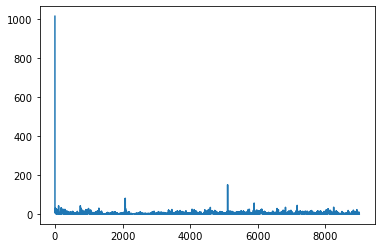

Movement_mouse_lateral_left 0       939.309381
1        13.587352
2        11.199992
3         7.447500
4         2.858243
           ...    
8995      0.485132
8996      0.294358
8997      0.174671
8998      1.267632
8999      0.639907
Name: Movement_mouse_lateral_left, Length: 9000, dtype: float64


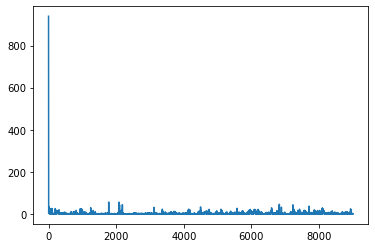

Movement_mouse_lateral_right 0       965.724197
1         0.682804
2         3.366204
3         3.254668
4         4.976765
           ...    
8995      1.484491
8996      0.739051
8997      0.000000
8998      0.000000
8999      1.187097
Name: Movement_mouse_lateral_right, Length: 9000, dtype: float64


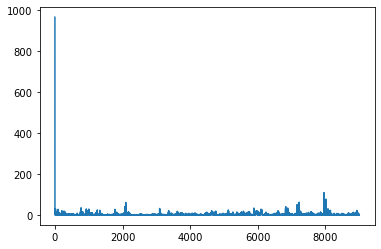

Mouse_polygon_size_change 0      -360.397855
1       -11.603459
2       -29.794228
3        -5.878747
4       -26.544313
           ...    
8995     -4.034809
8996     -1.779064
8997     -1.042810
8998     -1.549275
8999      1.502621
Name: Mouse_polygon_size_change, Length: 9000, dtype: float64


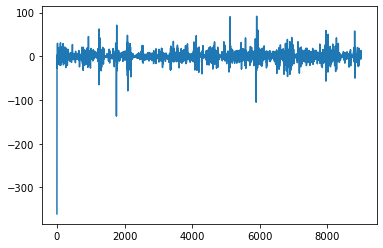

M1_largest_euclidean_distance_hull 0       136.682717
1       144.221006
2       156.848572
3       159.082743
4       175.320933
           ...    
8995    158.290022
8996    158.290022
8997    159.165091
8998    159.165091
8999    158.179608
Name: M1_largest_euclidean_distance_hull, Length: 9000, dtype: float64


M1_smallest_euclidean_distance_hull 0       35.688442
1       35.908065
2       37.618921
3       35.269867
4       35.590396
          ...    
8995    32.160639
8996    32.160639
8997    33.465155
8998    32.160639
8999    32.160639
Name: M1_smallest_euclidean_distance_hull, Length: 9000, dtype: float64


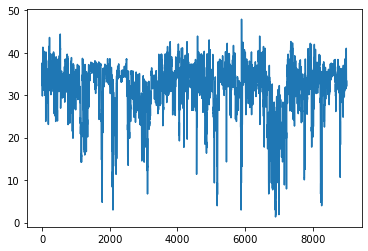

M1_mean_euclidean_distance_hull 0       77.373469
1       79.558410
2       86.853598
3       89.049557
4       95.738484
          ...    
8995    85.044314
8996    85.033325
8997    85.277825
8998    85.282945
8999    85.007955
Name: M1_mean_euclidean_distance_hull, Length: 9000, dtype: float64


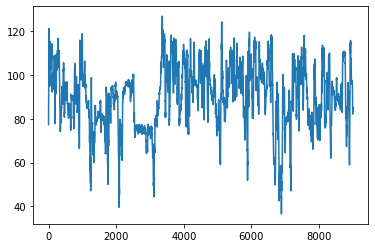

M1_sum_euclidean_distance_hull 0       3249.685700
1       3341.453208
2       3647.851131
3       3740.081386
4       4021.016310
           ...     
8995    3571.861205
8996    3571.399631
8997    3581.668651
8998    3581.883690
8999    3570.334095
Name: M1_sum_euclidean_distance_hull, Length: 9000, dtype: float64


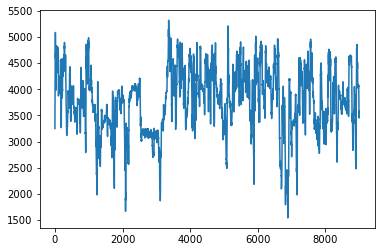

Total_movement_all_bodyparts_M1 0       7754.146518
1         72.241594
2        101.323295
3         52.859734
4         89.573178
           ...     
8995      10.831827
8996       3.445797
8997       1.820823
8998       3.426959
8999       6.129287
Name: Total_movement_all_bodyparts_M1, Length: 9000, dtype: float64


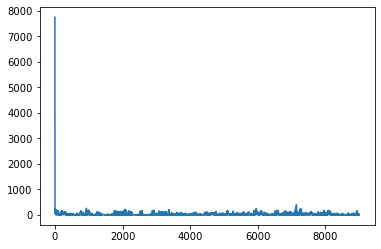

Mouse1_width_median_2 0       53.977310
1       53.675968
2       53.977310
3       54.845494
4       55.713678
          ...    
8995    46.652547
8996    46.652547
8997    46.652547
8998    46.652547
8999    46.652547
Name: Mouse1_width_median_2, Length: 9000, dtype: float64


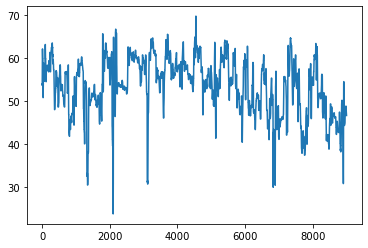

Mouse1_width_mean_2 0       53.977310
1       53.675968
2       54.355205
3       55.350689
4       56.719559
          ...    
8995    45.891924
8996    45.842973
8997    45.787423
8998    45.844166
8999    45.835521
Name: Mouse1_width_mean_2, Length: 9000, dtype: float64


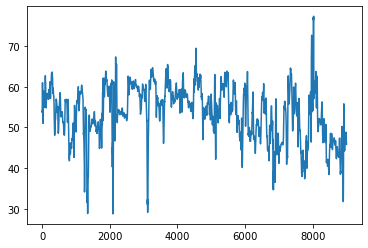

Mouse1_width_sum_2 0        53.977310
1       107.351936
2       163.065614
3       221.402758
4       283.597796
           ...    
8995    688.378861
8996    687.644594
8997    686.811341
8998    687.662488
8999    687.532822
Name: Mouse1_width_sum_2, Length: 9000, dtype: float64


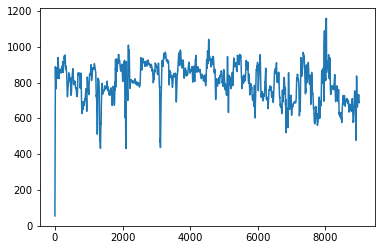

Mouse1_width_median_5 0       53.977310
1       53.675968
2       53.977310
3       54.845494
4       55.713678
          ...    
8995    43.182773
8996    44.206623
8997    45.831324
8998    47.051295
8999    47.459115
Name: Mouse1_width_median_5, Length: 9000, dtype: float64


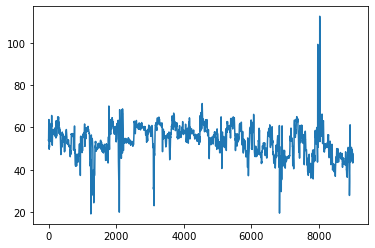

Mouse1_width_mean_5 0       53.977310
1       53.675968
2       54.355205
3       55.350689
4       56.719559
          ...    
8995    43.929870
8996    44.677811
8997    45.440983
8998    46.432134
8999    47.129766
Name: Mouse1_width_mean_5, Length: 9000, dtype: float64


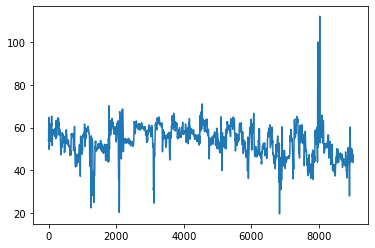

Mouse1_width_sum_5 0        53.977310
1       107.351936
2       163.065614
3       221.402758
4       283.597796
           ...    
8995    263.579222
8996    268.066864
8997    272.645899
8998    278.592802
8999    282.778594
Name: Mouse1_width_sum_5, Length: 9000, dtype: float64


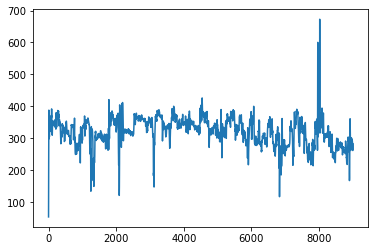

Mouse1_width_median_6 0       53.977310
1       53.675968
2       53.977310
3       54.845494
4       55.713678
          ...    
8995    43.403145
8996    45.010100
8997    46.652547
8998    47.450043
8999    47.468188
Name: Mouse1_width_median_6, Length: 9000, dtype: float64


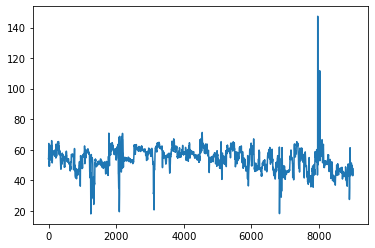

Mouse1_width_mean_6 0       53.977310
1       53.675968
2       54.355205
3       55.350689
4       56.719559
          ...    
8995    44.123364
8996    45.035542
8997    45.996805
8998    47.037931
8999    47.553699
Name: Mouse1_width_mean_6, Length: 9000, dtype: float64


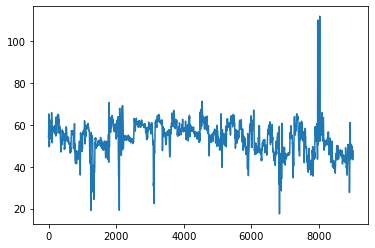

Mouse1_width_sum_6 0        53.977310
1       107.351936
2       163.065614
3       221.402758
4       283.597796
           ...    
8995    220.616821
8996    225.177711
8997    229.984024
8998    235.189657
8999    237.768494
Name: Mouse1_width_sum_6, Length: 9000, dtype: float64


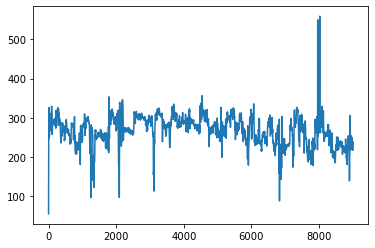

Mouse1_width_median_7.5 0       53.977310
1       53.675968
2       53.977310
3       54.845494
4       57.025411
          ...    
8995    44.206623
8996    45.831324
8997    47.051295
8998    47.459115
8999    47.528563
Name: Mouse1_width_median_7.5, Length: 9000, dtype: float64


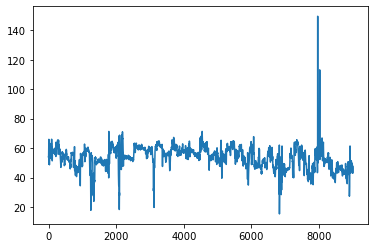

Mouse1_width_mean_7.5 0       53.977310
1       53.675968
2       54.355205
3       55.350689
4       57.405121
          ...    
8995    44.431917
8996    45.628959
8997    46.645220
8998    47.544889
8999    47.778987
Name: Mouse1_width_mean_7.5, Length: 9000, dtype: float64


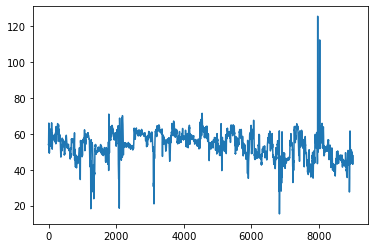

Mouse1_width_sum_7.5 0        53.977310
1       107.351936
2       163.065614
3       221.402758
4       229.620486
           ...    
8995    177.727668
8996    182.515836
8997    186.580879
8998    190.179556
8999    191.115946
Name: Mouse1_width_sum_7.5, Length: 9000, dtype: float64


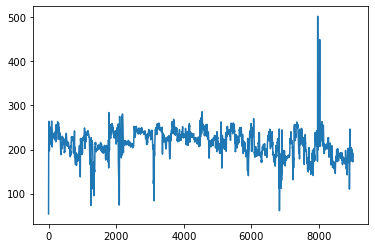

Mouse1_width_median_15 0       53.977310
1       53.675968
2       54.544152
3       57.025411
4       60.266091
          ...    
8995    45.831324
8996    47.051295
8997    47.459115
8998    48.038483
8999    48.098858
Name: Mouse1_width_median_15, Length: 9000, dtype: float64


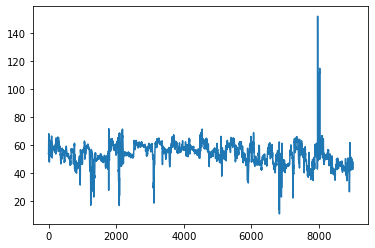

Mouse1_width_mean_15 0       53.977310
1       53.675968
2       54.544152
3       57.025411
4       60.266091
          ...    
8995    45.831324
8996    47.051295
8997    47.459115
8998    48.038483
8999    48.098858
Name: Mouse1_width_mean_15, Length: 9000, dtype: float64


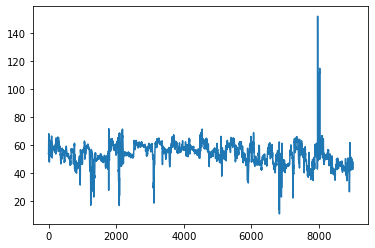

Mouse1_width_sum_15 0        53.977310
1       107.351936
2       109.088304
3       114.050822
4       120.532182
           ...    
8995     91.662648
8996     94.102590
8997     94.918231
8998     96.076966
8999     96.197715
Name: Mouse1_width_sum_15, Length: 9000, dtype: float64


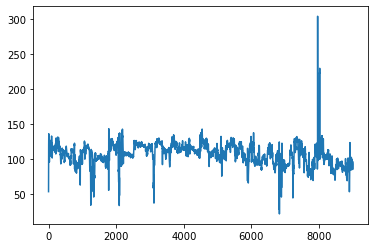

Mouse1_mean_euclid_distances_median_2 0       77.373469
1       78.465939
2       79.558410
3       83.206004
4       86.853598
          ...    
8995    85.044314
8996    85.033325
8997    85.033325
8998    85.033325
8999    85.007955
Name: Mouse1_mean_euclid_distances_median_2, Length: 9000, dtype: float64


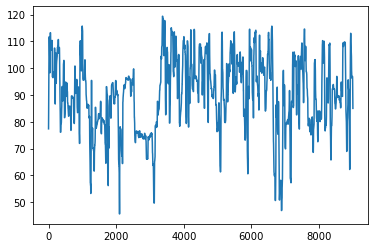

Mouse1_mean_euclid_distances_mean_2 0       77.373469
1       78.465939
2       81.261826
3       83.208758
4       85.714704
          ...    
8995    87.833257
8996    87.053728
8997    86.303614
8998    85.537151
8999    84.871899
Name: Mouse1_mean_euclid_distances_mean_2, Length: 9000, dtype: float64


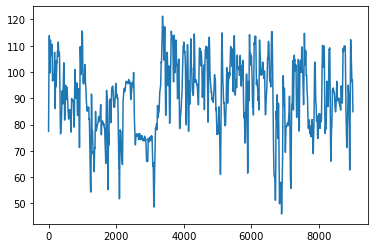

Mouse1_mean_euclid_distances_sum_2 0         77.373469
1        156.931879
2        243.785477
3        332.835034
4        428.573517
           ...     
8995    1317.498859
8996    1305.805923
8997    1294.554215
8998    1283.057261
8999    1273.078480
Name: Mouse1_mean_euclid_distances_sum_2, Length: 9000, dtype: float64


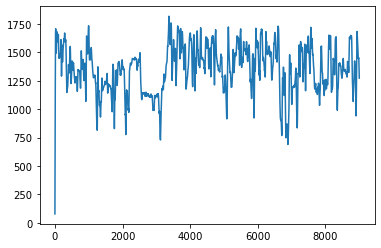

Mouse1_mean_euclid_distances_median_5 0       77.373469
1       78.465939
2       79.558410
3       83.206004
4       86.853598
          ...    
8995    82.491756
8996    83.287860
8997    84.531499
8998    85.038819
8999    85.038819
Name: Mouse1_mean_euclid_distances_median_5, Length: 9000, dtype: float64


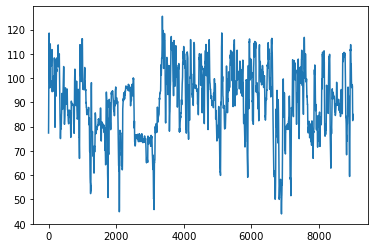

Mouse1_mean_euclid_distances_mean_5 0       77.373469
1       78.465939
2       81.261826
3       83.208758
4       85.714704
          ...    
8995    83.068676
8996    83.501319
8997    83.956616
8998    84.472195
8999    84.946006
Name: Mouse1_mean_euclid_distances_mean_5, Length: 9000, dtype: float64


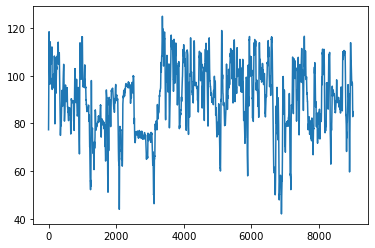

Mouse1_mean_euclid_distances_sum_5 0        77.373469
1       156.931879
2       243.785477
3       332.835034
4       428.573517
           ...    
8995    498.412056
8996    501.007915
8997    503.739693
8998    506.833169
8999    509.676037
Name: Mouse1_mean_euclid_distances_sum_5, Length: 9000, dtype: float64


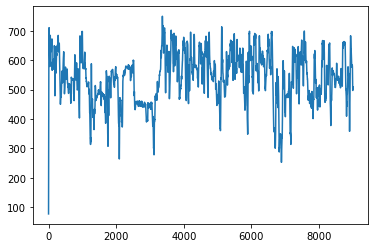

Mouse1_mean_euclid_distances_median_6 0       77.373469
1       78.465939
2       79.558410
3       83.206004
4       86.853598
          ...    
8995    82.546046
8996    84.029673
8997    85.033325
8998    85.044314
8999    85.044314
Name: Mouse1_mean_euclid_distances_median_6, Length: 9000, dtype: float64


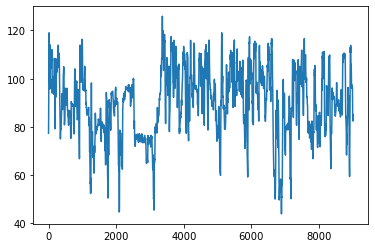

Mouse1_mean_euclid_distances_mean_6 0       77.373469
1       78.465939
2       81.261826
3       83.208758
4       85.714704
          ...    
8995    83.194918
8996    83.692374
8997    84.310045
8998    84.933616
8999    85.129273
Name: Mouse1_mean_euclid_distances_mean_6, Length: 9000, dtype: float64


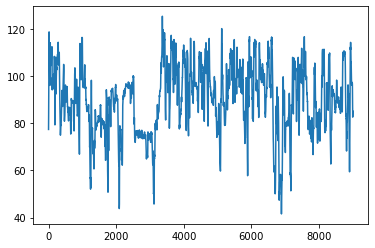

Mouse1_mean_euclid_distances_sum_6 0        77.373469
1       156.931879
2       243.785477
3       332.835034
4       428.573517
           ...    
8995    415.974590
8996    418.461868
8997    421.550224
8998    424.668082
8999    425.646364
Name: Mouse1_mean_euclid_distances_sum_6, Length: 9000, dtype: float64


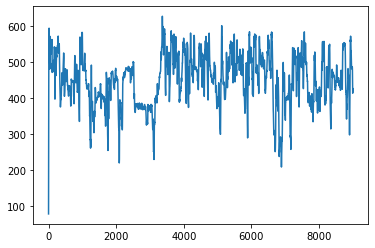

Mouse1_mean_euclid_distances_median_7.5 0       77.373469
1       78.465939
2       79.558410
3       83.206004
4       87.951578
          ...    
8995    83.109571
8996    84.531499
8997    85.038819
8998    85.161070
8999    85.155575
Name: Mouse1_mean_euclid_distances_median_7.5, Length: 9000, dtype: float64


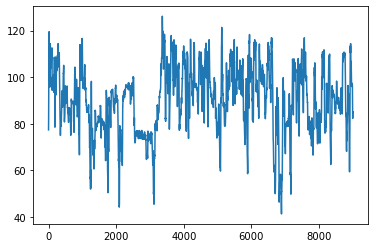

Mouse1_mean_euclid_distances_mean_7.5 0       77.373469
1       78.465939
2       81.261826
3       83.208758
4       87.800012
          ...    
8995    83.357136
8996    84.068100
8997    84.846284
8998    85.159602
8999    85.150512
Name: Mouse1_mean_euclid_distances_mean_7.5, Length: 9000, dtype: float64


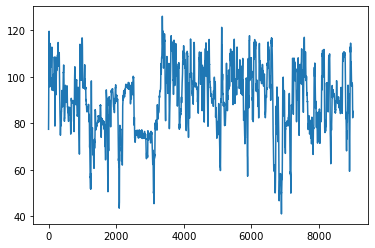

Mouse1_mean_euclid_distances_sum_7.5 0        77.373469
1       156.931879
2       243.785477
3       332.835034
4       351.200048
           ...    
8995    333.428544
8996    336.272399
8997    339.385137
8998    340.638409
8999    340.602049
Name: Mouse1_mean_euclid_distances_sum_7.5, Length: 9000, dtype: float64


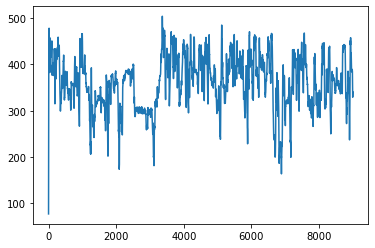

Mouse1_mean_euclid_distances_median_15 0       77.373469
1       78.465939
2       83.206004
3       87.951578
4       92.394020
          ...    
8995    84.536994
8996    85.038819
8997    85.155575
8998    85.280385
8999    85.145450
Name: Mouse1_mean_euclid_distances_median_15, Length: 9000, dtype: float64


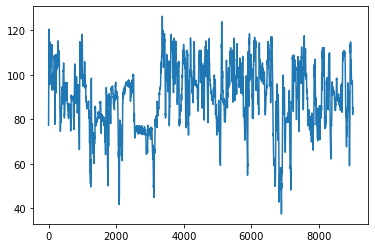

Mouse1_mean_euclid_distances_mean_15 0       77.373469
1       78.465939
2       83.206004
3       87.951578
4       92.394020
          ...    
8995    84.536994
8996    85.038819
8997    85.155575
8998    85.280385
8999    85.145450
Name: Mouse1_mean_euclid_distances_mean_15, Length: 9000, dtype: float64


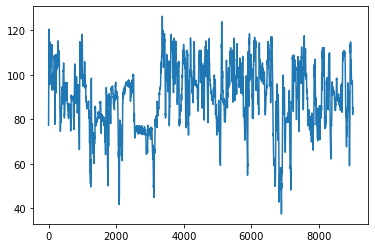

Mouse1_mean_euclid_distances_sum_15 0        77.373469
1       156.931879
2       166.412008
3       175.903155
4       184.788040
           ...    
8995    169.073987
8996    170.077639
8997    170.311150
8998    170.560770
8999    170.290900
Name: Mouse1_mean_euclid_distances_sum_15, Length: 9000, dtype: float64


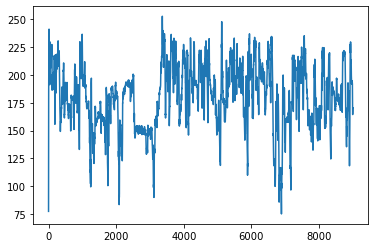

Mouse1_smallest_euclid_distances_median_2 0       35.688442
1       35.798253
2       35.908065
3       35.798253
4       35.688442
          ...    
8995    35.688442
8996    35.688442
8997    35.688442
8998    35.688442
8999    35.688442
Name: Mouse1_smallest_euclid_distances_median_2, Length: 9000, dtype: float64


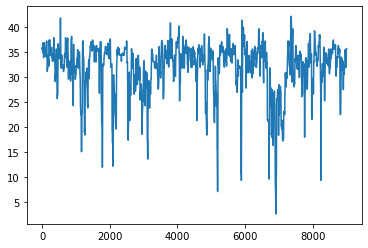

Mouse1_smallest_euclid_distances_mean_2 0       35.688442
1       35.798253
2       36.405142
3       36.121324
4       36.015138
          ...    
8995    35.448479
8996    35.461193
8997    35.560874
8998    35.573588
8999    35.507602
Name: Mouse1_smallest_euclid_distances_mean_2, Length: 9000, dtype: float64


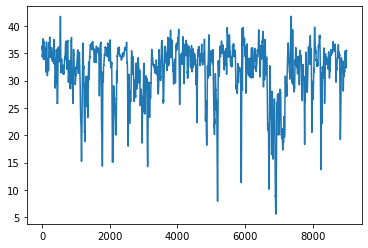

Mouse1_smallest_euclid_distances_sum_2 0        35.688442
1        71.596507
2       109.215427
3       144.485294
4       180.075690
           ...    
8995    531.727187
8996    531.917891
8997    533.413111
8998    533.603815
8999    532.614026
Name: Mouse1_smallest_euclid_distances_sum_2, Length: 9000, dtype: float64


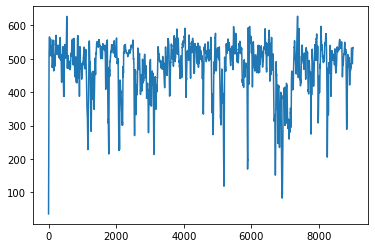

Mouse1_smallest_euclid_distances_median_5 0       35.688442
1       35.798253
2       35.908065
3       35.798253
4       35.688442
          ...    
8995    35.909984
8996    33.465155
8997    33.465155
8998    32.812897
8999    32.160639
Name: Mouse1_smallest_euclid_distances_median_5, Length: 9000, dtype: float64


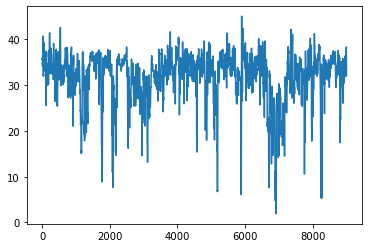

Mouse1_smallest_euclid_distances_mean_5 0       35.688442
1       35.798253
2       36.405142
3       36.121324
4       36.015138
          ...    
8995    36.154941
8996    35.111201
8997    33.845259
8998    32.812897
8999    32.595478
Name: Mouse1_smallest_euclid_distances_mean_5, Length: 9000, dtype: float64


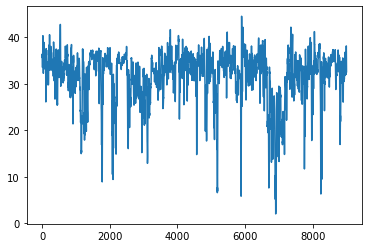

Mouse1_smallest_euclid_distances_sum_5 0        35.688442
1        71.596507
2       109.215427
3       144.485294
4       180.075690
           ...    
8995    216.929648
8996    210.667208
8997    203.071555
8998    196.877382
8999    195.572867
Name: Mouse1_smallest_euclid_distances_sum_5, Length: 9000, dtype: float64


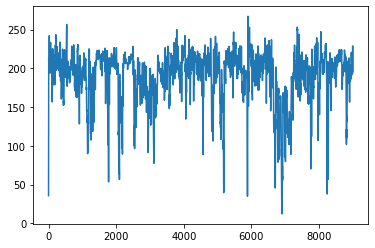

Mouse1_smallest_euclid_distances_median_6 0       35.688442
1       35.798253
2       35.908065
3       35.798253
4       35.688442
          ...    
8995    33.465155
8996    33.465155
8997    33.465155
8998    32.160639
8999    32.160639
Name: Mouse1_smallest_euclid_distances_median_6, Length: 9000, dtype: float64


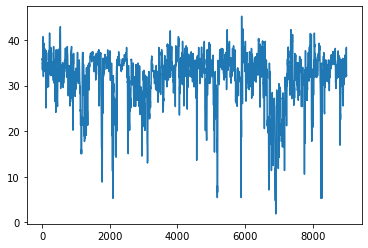

Mouse1_smallest_euclid_distances_mean_6 0       35.688442
1       35.798253
2       36.405142
3       36.121324
4       36.015138
          ...    
8995    35.701314
8996    33.921280
8997    32.943349
8998    32.682445
8999    32.421542
Name: Mouse1_smallest_euclid_distances_mean_6, Length: 9000, dtype: float64


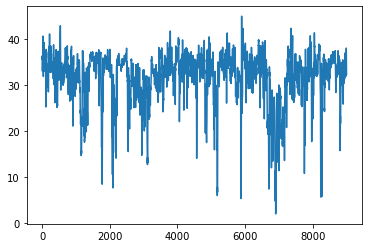

Mouse1_smallest_euclid_distances_sum_6 0        35.688442
1        71.596507
2       109.215427
3       144.485294
4       180.075690
           ...    
8995    178.506568
8996    169.606401
8997    164.716743
8998    163.412228
8999    162.107712
Name: Mouse1_smallest_euclid_distances_sum_6, Length: 9000, dtype: float64


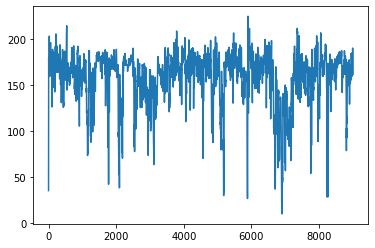

Mouse1_smallest_euclid_distances_median_7.5 0       35.688442
1       35.798253
2       35.908065
3       35.798253
4       35.749231
          ...    
8995    33.465155
8996    32.812897
8997    32.812897
8998    32.160639
8999    32.160639
Name: Mouse1_smallest_euclid_distances_median_7.5, Length: 9000, dtype: float64


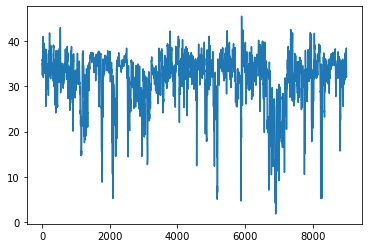

Mouse1_smallest_euclid_distances_mean_7.5 0       35.688442
1       35.798253
2       36.405142
3       36.121324
4       36.096812
          ...    
8995    34.361440
8996    32.812897
8997    32.812897
8998    32.486768
8999    32.486768
Name: Mouse1_smallest_euclid_distances_mean_7.5, Length: 9000, dtype: float64


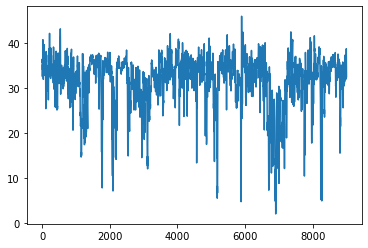

Mouse1_smallest_euclid_distances_sum_7.5 0        35.688442
1        71.596507
2       109.215427
3       144.485294
4       144.387249
           ...    
8995    137.445761
8996    131.251588
8997    131.251588
8998    129.947073
8999    129.947073
Name: Mouse1_smallest_euclid_distances_sum_7.5, Length: 9000, dtype: float64


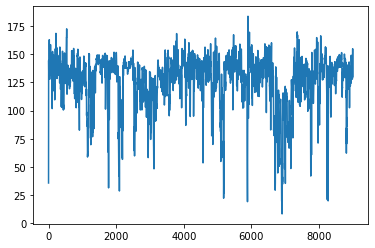

Mouse1_smallest_euclid_distances_median_15 0       35.688442
1       35.798253
2       36.763493
3       36.444394
4       35.430132
          ...    
8995    32.812897
8996    32.160639
8997    32.812897
8998    32.812897
8999    32.160639
Name: Mouse1_smallest_euclid_distances_median_15, Length: 9000, dtype: float64


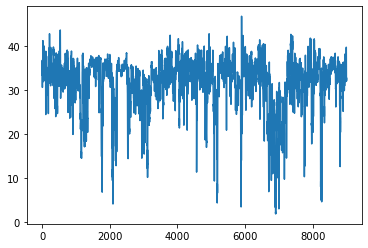

Mouse1_smallest_euclid_distances_mean_15 0       35.688442
1       35.798253
2       36.763493
3       36.444394
4       35.430132
          ...    
8995    32.812897
8996    32.160639
8997    32.812897
8998    32.812897
8999    32.160639
Name: Mouse1_smallest_euclid_distances_mean_15, Length: 9000, dtype: float64


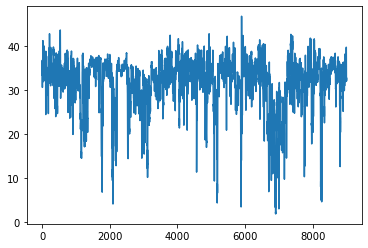

Mouse1_smallest_euclid_distances_sum_15 0       35.688442
1       71.596507
2       73.526986
3       72.888787
4       70.860263
          ...    
8995    65.625794
8996    64.321279
8997    65.625794
8998    65.625794
8999    64.321279
Name: Mouse1_smallest_euclid_distances_sum_15, Length: 9000, dtype: float64


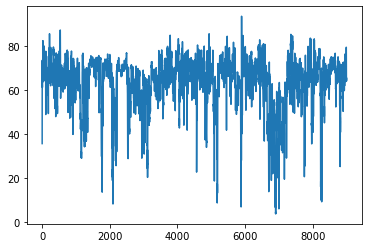

Mouse1_largest_euclid_distances_median_2 0       136.682717
1       140.451862
2       144.221006
3       150.534789
4       156.848572
           ...    
8995    158.422417
8996    158.290022
8997    158.290022
8998    158.290022
8999    158.290022
Name: Mouse1_largest_euclid_distances_median_2, Length: 9000, dtype: float64


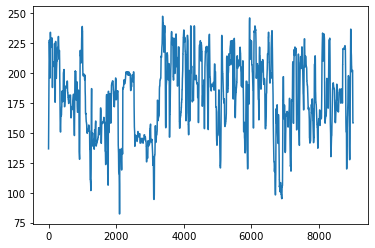

Mouse1_largest_euclid_distances_mean_2 0       136.682717
1       140.451862
2       145.917432
3       149.208760
4       154.431194
           ...    
8995    170.848441
8996    167.918809
8997    165.047514
8998    162.134529
8999    159.713371
Name: Mouse1_largest_euclid_distances_mean_2, Length: 9000, dtype: float64


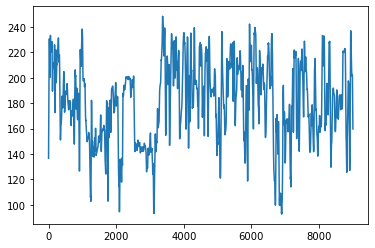

Mouse1_largest_euclid_distances_sum_2 0        136.682717
1        280.903724
2        437.752296
3        596.835039
4        772.155972
           ...     
8995    2562.726609
8996    2518.782128
8997    2475.712716
8998    2432.017931
8999    2395.700572
Name: Mouse1_largest_euclid_distances_sum_2, Length: 9000, dtype: float64


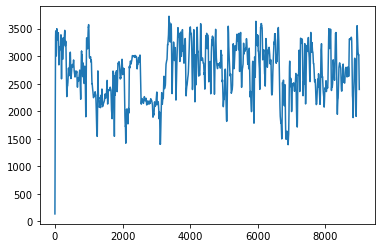

Mouse1_largest_euclid_distances_median_5 0       136.682717
1       140.451862
2       144.221006
3       150.534789
4       156.848572
           ...    
8995    155.351583
8996    155.601382
8997    156.810962
8998    158.290022
8999    158.290022
Name: Mouse1_largest_euclid_distances_median_5, Length: 9000, dtype: float64


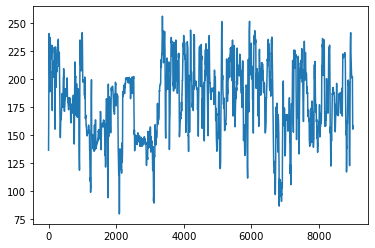

Mouse1_largest_euclid_distances_mean_5 0       136.682717
1       140.451862
2       145.917432
3       149.208760
4       154.431194
           ...    
8995    155.308329
8996    155.794788
8997    156.343827
8998    157.125558
8999    158.070289
Name: Mouse1_largest_euclid_distances_mean_5, Length: 9000, dtype: float64


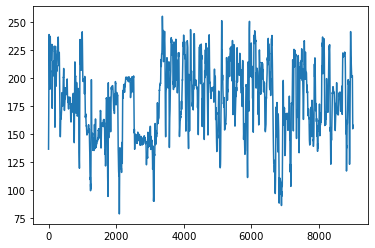

Mouse1_largest_euclid_distances_sum_5 0       136.682717
1       280.903724
2       437.752296
3       596.835039
4       772.155972
           ...    
8995    931.849972
8996    934.768729
8997    938.062960
8998    942.753346
8999    948.421736
Name: Mouse1_largest_euclid_distances_sum_5, Length: 9000, dtype: float64


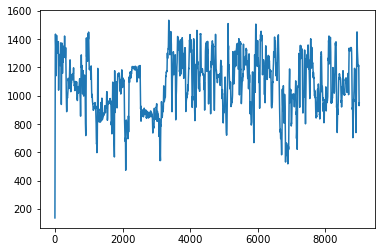

Mouse1_largest_euclid_distances_median_6 0       136.682717
1       140.451862
2       144.221006
3       150.534789
4       156.848572
           ...    
8995    155.331902
8996    155.331902
8997    158.290022
8998    158.290022
8999    158.290022
Name: Mouse1_largest_euclid_distances_median_6, Length: 9000, dtype: float64


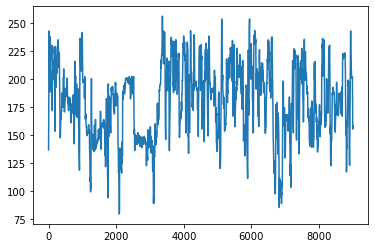

Mouse1_largest_euclid_distances_mean_6 0       136.682717
1       140.451862
2       145.917432
3       149.208760
4       154.431194
           ...    
8995    155.295741
8996    155.779574
8997    156.717651
8998    158.048426
8999    158.617967
Name: Mouse1_largest_euclid_distances_mean_6, Length: 9000, dtype: float64


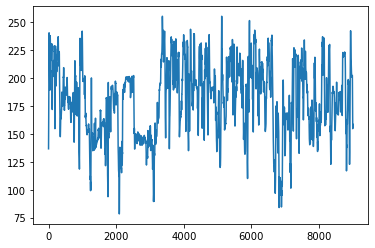

Mouse1_largest_euclid_distances_sum_6 0       136.682717
1       280.903724
2       437.752296
3       596.835039
4       772.155972
           ...    
8995    776.478707
8996    778.897868
8997    783.588254
8998    790.242128
8999    793.089834
Name: Mouse1_largest_euclid_distances_sum_6, Length: 9000, dtype: float64


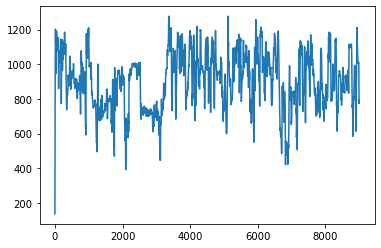

Mouse1_largest_euclid_distances_median_7.5 0       136.682717
1       140.451862
2       144.221006
3       150.534789
4       157.965658
           ...    
8995    154.903304
8996    156.810962
8997    158.290022
8998    158.727556
8999    158.727556
Name: Mouse1_largest_euclid_distances_median_7.5, Length: 9000, dtype: float64


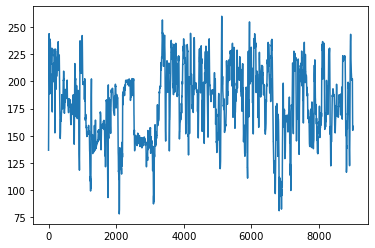

Mouse1_largest_euclid_distances_mean_7.5 0       136.682717
1       140.451862
2       145.917432
3       149.208760
4       158.868314
           ...    
8995    155.151962
8996    156.105791
8997    157.769259
8998    158.727556
8999    158.699953
Name: Mouse1_largest_euclid_distances_mean_7.5, Length: 9000, dtype: float64


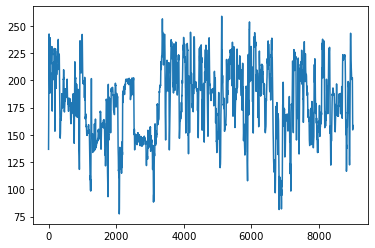

Mouse1_largest_euclid_distances_sum_7.5 0       136.682717
1       280.903724
2       437.752296
3       596.835039
4       635.473255
           ...    
8995    620.607847
8996    624.423163
8997    631.077037
8998    634.910226
8999    634.799812
Name: Mouse1_largest_euclid_distances_sum_7.5, Length: 9000, dtype: float64


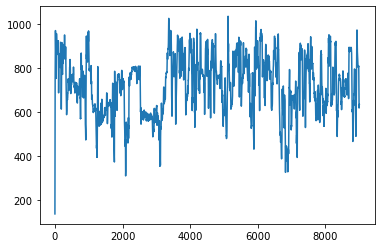

Mouse1_largest_euclid_distances_median_15 0       136.682717
1       140.451862
2       150.534789
3       157.965658
4       167.201838
           ...    
8995    156.810962
8996    158.290022
8997    158.727556
8998    159.165091
8999    158.672349
Name: Mouse1_largest_euclid_distances_median_15, Length: 9000, dtype: float64


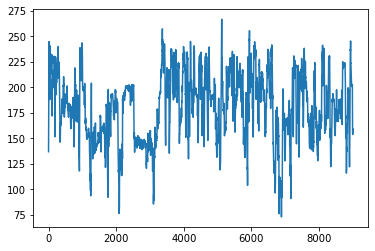

Mouse1_largest_euclid_distances_mean_15 0       136.682717
1       140.451862
2       150.534789
3       157.965658
4       167.201838
           ...    
8995    156.810962
8996    158.290022
8997    158.727556
8998    159.165091
8999    158.672349
Name: Mouse1_largest_euclid_distances_mean_15, Length: 9000, dtype: float64


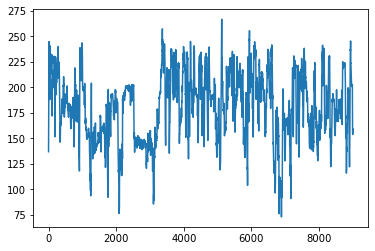

Mouse1_largest_euclid_distances_sum_15 0       136.682717
1       280.903724
2       301.069579
3       315.931316
4       334.403676
           ...    
8995    313.621924
8996    316.580044
8997    317.455113
8998    318.330182
8999    317.344699
Name: Mouse1_largest_euclid_distances_sum_15, Length: 9000, dtype: float64


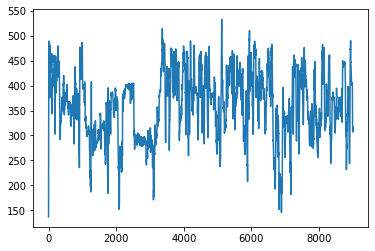

Tail_base_movement_M1_median_2 0       912.733331
1       459.803629
2         6.873927
3         5.337417
4         3.800908
           ...    
8995      0.183739
8996      0.183739
8997      0.183739
8998      0.213176
8999      0.213176
Name: Tail_base_movement_M1_median_2, Length: 9000, dtype: float64


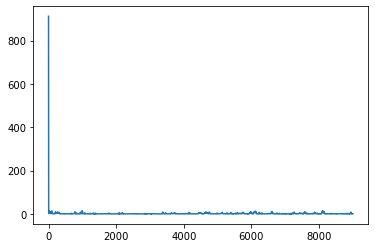

Tail_base_movement_M1_mean_2 0       912.733331
1       459.803629
2       306.591419
3       230.893791
4       184.837608
           ...    
8995      0.238939
8996      0.242988
8997      0.262573
8998      0.286719
8999      0.269073
Name: Tail_base_movement_M1_mean_2, Length: 9000, dtype: float64


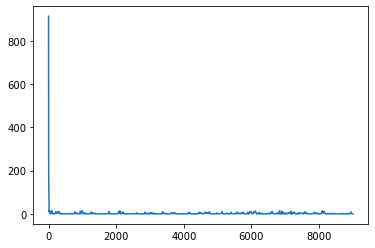

Tail_base_movement_M1_sum_2 0       912.733331
1       919.607258
2       919.774257
3       923.575164
4       924.188041
           ...    
8995      3.584081
8996      3.644813
8997      3.938596
8998      4.300791
8999      4.036096
Name: Tail_base_movement_M1_sum_2, Length: 9000, dtype: float64


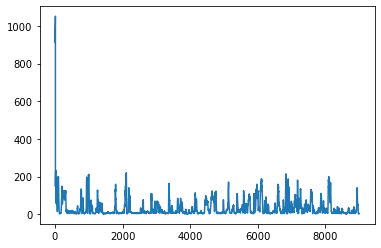

Tail_base_movement_M1_median_5 0       912.733331
1       459.803629
2         6.873927
3         5.337417
4         3.800908
           ...    
8995      0.198458
8996      0.165141
8997      0.198458
8998      0.272967
8999      0.298697
Name: Tail_base_movement_M1_median_5, Length: 9000, dtype: float64


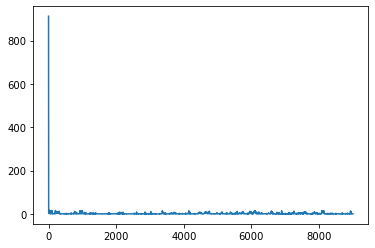

Tail_base_movement_M1_mean_5 0       912.733331
1       459.803629
2       306.591419
3       230.893791
4       184.837608
           ...    
8995      0.185972
8996      0.170999
8997      0.284826
8998      0.309662
8999      0.333478
Name: Tail_base_movement_M1_mean_5, Length: 9000, dtype: float64


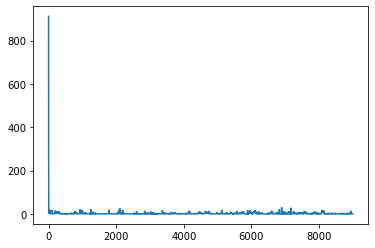

Tail_base_movement_M1_sum_5 0       912.733331
1       919.607258
2       919.774257
3       923.575164
4       924.188041
           ...    
8995      1.115830
8996      1.025992
8997      1.708954
8998      1.857972
8999      2.000867
Name: Tail_base_movement_M1_sum_5, Length: 9000, dtype: float64


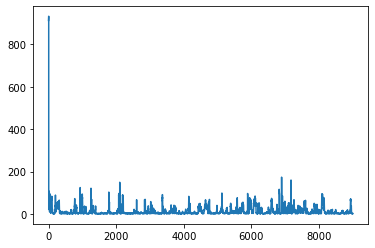

Tail_base_movement_M1_median_6 0       912.733331
1       459.803629
2         6.873927
3         5.337417
4         3.800908
           ...    
8995      0.183739
8996      0.183739
8997      0.183739
8998      0.362195
8999      0.362195
Name: Tail_base_movement_M1_median_6, Length: 9000, dtype: float64


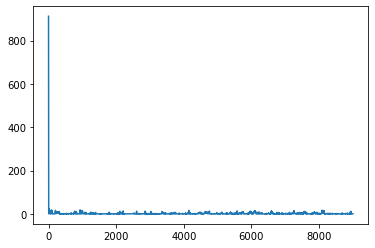

Tail_base_movement_M1_mean_6 0       912.733331
1       459.803629
2       306.591419
3       230.893791
4       184.837608
           ...    
8995      0.175890
8996      0.205198
8997      0.299156
8998      0.353133
8999      0.363426
Name: Tail_base_movement_M1_mean_6, Length: 9000, dtype: float64


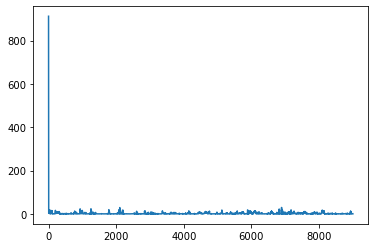

Tail_base_movement_M1_sum_6 0       912.733331
1       919.607258
2       919.774257
3       923.575164
4       924.188041
           ...    
8995      0.879450
8996      1.025992
8997      1.495778
8998      1.765667
8999      1.817128
Name: Tail_base_movement_M1_sum_6, Length: 9000, dtype: float64


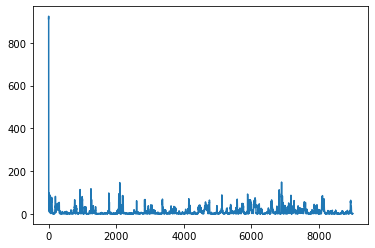

Tail_base_movement_M1_median_7.5 0       912.733331
1       459.803629
2         6.873927
3         5.337417
4         2.206892
           ...    
8995      0.198458
8996      0.165141
8997      0.286984
8998      0.376212
8999      0.298697
Name: Tail_base_movement_M1_median_7.5, Length: 9000, dtype: float64


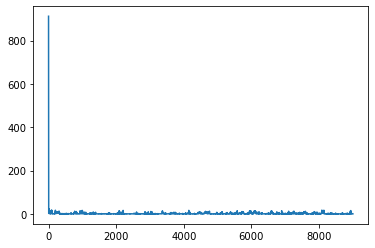

Tail_base_movement_M1_mean_7.5 0       912.733331
1       459.803629
2       306.591419
3       230.893791
4         2.863678
           ...    
8995      0.219862
8996      0.203204
8997      0.350868
8998      0.395482
8999      0.356725
Name: Tail_base_movement_M1_mean_7.5, Length: 9000, dtype: float64


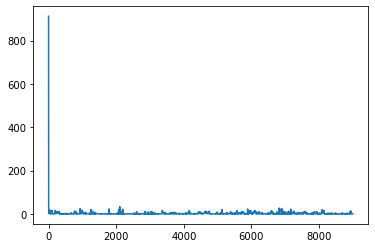

Tail_base_movement_M1_sum_7.5 0       912.733331
1       919.607258
2       919.774257
3       923.575164
4        11.454710
           ...    
8995      0.879450
8996      0.812816
8997      1.403472
8998      1.581928
8999      1.426898
Name: Tail_base_movement_M1_sum_7.5, Length: 9000, dtype: float64


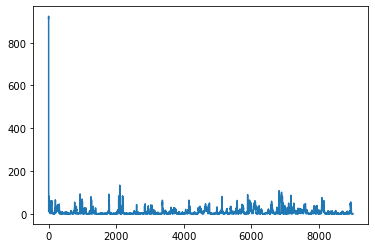

Tail_base_movement_M1_median_15 0       912.733331
1       459.803629
2         3.520463
3         1.983953
4         2.206892
           ...    
8995      0.286984
8996      0.268386
8997      0.414752
8998      0.522578
8999      0.298697
Name: Tail_base_movement_M1_median_15, Length: 9000, dtype: float64


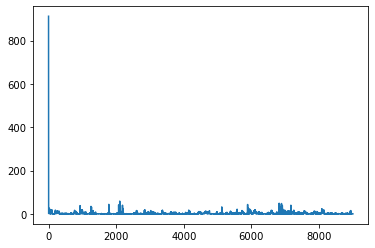

Tail_base_movement_M1_mean_15 0       912.733331
1       459.803629
2         3.520463
3         1.983953
4         2.206892
           ...    
8995      0.286984
8996      0.268386
8997      0.414752
8998      0.522578
8999      0.298697
Name: Tail_base_movement_M1_mean_15, Length: 9000, dtype: float64


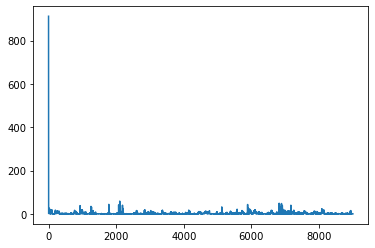

Tail_base_movement_M1_sum_15 0       912.733331
1       919.607258
2         7.040926
3         3.967907
4         4.413784
           ...    
8995      0.573969
8996      0.536771
8997      0.829504
8998      1.045156
8999      0.597395
Name: Tail_base_movement_M1_sum_15, Length: 9000, dtype: float64


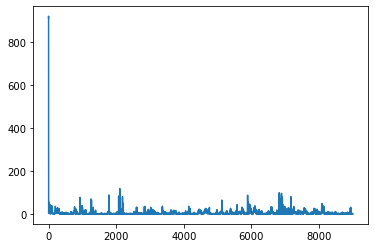

Centroid_movement_M1_median_2 0       987.182983
1       497.977287
2        17.754549
3        13.263069
4        12.025754
           ...    
8995      1.268856
8996      1.180601
8997      1.180601
8998      1.087022
8999      1.052625
Name: Centroid_movement_M1_median_2, Length: 9000, dtype: float64


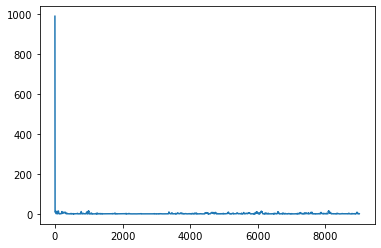

Centroid_movement_M1_mean_2 0       987.182983
1       497.977287
2       337.903041
3       255.229021
4       206.588368
           ...    
8995      1.439902
8996      1.259263
8997      1.259263
8998      1.179471
8999      1.076680
Name: Centroid_movement_M1_mean_2, Length: 9000, dtype: float64


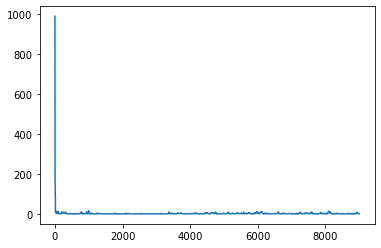

Centroid_movement_M1_sum_2 0        987.182983
1        995.954573
2       1013.709122
3       1020.916084
4       1032.941838
           ...     
8995      21.598529
8996      18.888940
8997      18.888940
8998      17.692063
8999      16.150206
Name: Centroid_movement_M1_sum_2, Length: 9000, dtype: float64


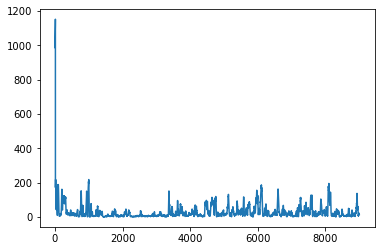

Centroid_movement_M1_median_5 0       987.182983
1       497.977287
2        17.754549
3        13.263069
4        12.025754
           ...    
8995      1.224729
8996      1.116613
8997      1.039339
8998      0.693486
8999      0.423204
Name: Centroid_movement_M1_median_5, Length: 9000, dtype: float64


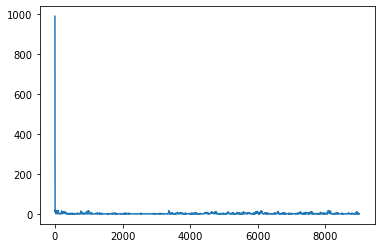

Centroid_movement_M1_mean_5 0       987.182983
1       497.977287
2       337.903041
3       255.229021
4       206.588368
           ...    
8995      1.473192
8996      1.078739
8997      0.903302
8998      0.698990
8999      0.511787
Name: Centroid_movement_M1_mean_5, Length: 9000, dtype: float64


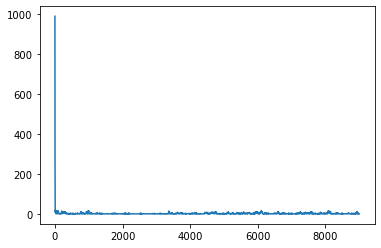

Centroid_movement_M1_sum_5 0        987.182983
1        995.954573
2       1013.709122
3       1020.916084
4       1032.941838
           ...     
8995       8.839154
8996       6.472435
8997       5.419810
8998       4.193943
8999       3.070722
Name: Centroid_movement_M1_sum_5, Length: 9000, dtype: float64


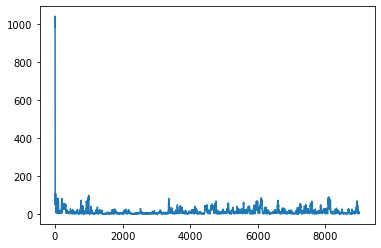

Centroid_movement_M1_median_6 0       987.182983
1       497.977287
2        17.754549
3        13.263069
4        12.025754
           ...    
8995      1.180601
8996      1.180601
8997      0.898076
8998      0.488896
8999      0.357513
Name: Centroid_movement_M1_median_6, Length: 9000, dtype: float64


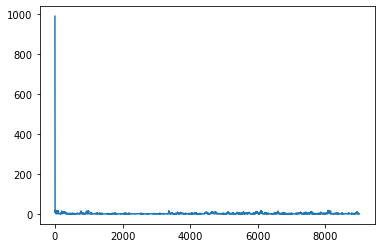

Centroid_movement_M1_mean_6 0       987.182983
1       497.977287
2       337.903041
3       255.229021
4       206.588368
           ...    
8995      1.196708
8996      1.083962
8997      0.767286
8998      0.602668
8999      0.360373
Name: Centroid_movement_M1_mean_6, Length: 9000, dtype: float64


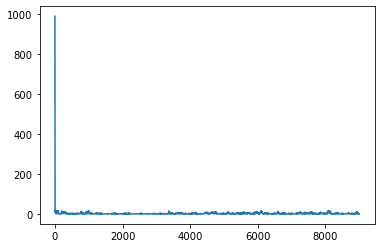

Centroid_movement_M1_sum_6 0        987.182983
1        995.954573
2       1013.709122
3       1020.916084
4       1032.941838
           ...     
8995       5.983539
8996       5.419810
8997       3.836430
8998       3.013341
8999       1.801866
Name: Centroid_movement_M1_sum_6, Length: 9000, dtype: float64


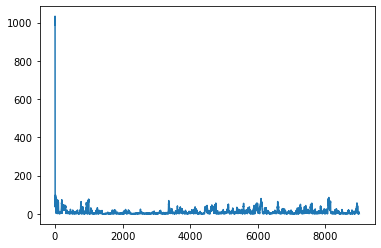

Centroid_movement_M1_median_7.5 0       987.182983
1       497.977287
2        17.754549
3        13.263069
4        10.398672
           ...    
8995      1.224729
8996      1.039339
8997      0.693486
8998      0.423204
8999      0.207447
Name: Centroid_movement_M1_median_7.5, Length: 9000, dtype: float64


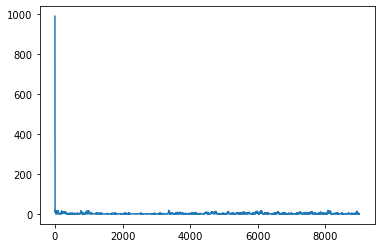

Centroid_movement_M1_mean_7.5 0       987.182983
1       497.977287
2       337.903041
3       255.229021
4        11.439714
           ...    
8995      1.232729
8996      0.959107
8997      0.663957
8998      0.436121
8999      0.225947
Name: Centroid_movement_M1_mean_7.5, Length: 9000, dtype: float64


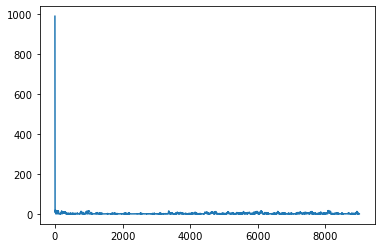

Centroid_movement_M1_sum_7.5 0        987.182983
1        995.954573
2       1013.709122
3       1020.916084
4         45.758855
           ...     
8995       4.930914
8996       3.836430
8997       2.655829
8998       1.744485
8999       0.903789
Name: Centroid_movement_M1_sum_7.5, Length: 9000, dtype: float64


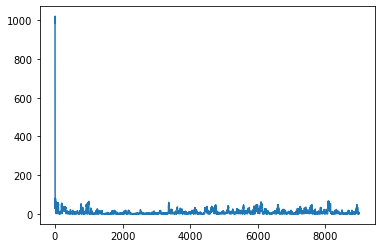

Centroid_movement_M1_median_15 0       987.182983
1       497.977287
2        13.263069
3        12.480755
4         9.616358
           ...    
8995      1.083466
8996      0.693486
8997      0.244448
8998      0.178756
8999      0.207447
Name: Centroid_movement_M1_median_15, Length: 9000, dtype: float64


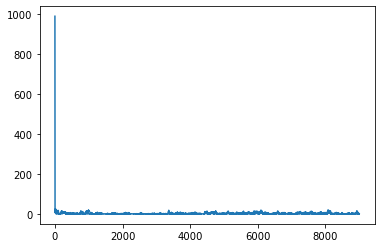

Centroid_movement_M1_mean_15 0       987.182983
1       497.977287
2        13.263069
3        12.480755
4         9.616358
           ...    
8995      1.083466
8996      0.693486
8997      0.244448
8998      0.178756
8999      0.207447
Name: Centroid_movement_M1_mean_15, Length: 9000, dtype: float64


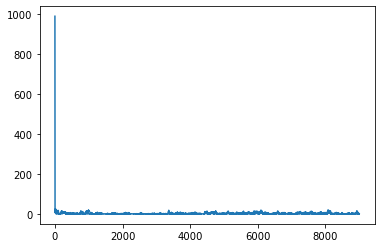

Centroid_movement_M1_sum_15 0       987.182983
1       995.954573
2        26.526139
3        24.961511
4        19.232716
           ...    
8995      2.166933
8996      1.386973
8997      0.488896
8998      0.357513
8999      0.414893
Name: Centroid_movement_M1_sum_15, Length: 9000, dtype: float64


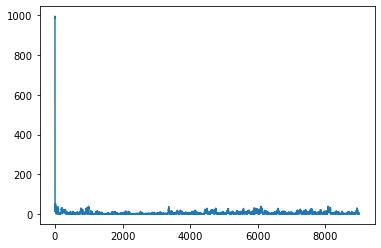

Tail_end_movement_M1_median_2 0       843.167366
1       424.133255
2         5.099144
3         3.544440
4         5.099144
           ...    
8995      0.533920
8996      0.533920
8997      0.533920
8998      0.533920
8999      0.533920
Name: Tail_end_movement_M1_median_2, Length: 9000, dtype: float64


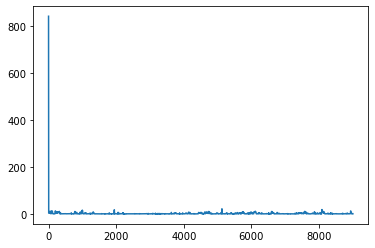

Tail_end_movement_M1_mean_2 0       843.167366
1       424.133255
2       283.068391
3       212.798727
4       172.485276
           ...    
8995      0.665679
8996      0.695306
8997      0.689430
8998      0.701321
8999      0.789755
Name: Tail_end_movement_M1_mean_2, Length: 9000, dtype: float64


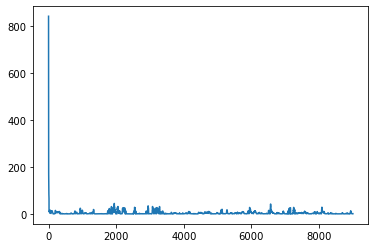

Tail_end_movement_M1_sum_2 0       843.167366
1       848.266509
2       849.205174
3       851.194909
4       862.426382
           ...    
8995      9.985188
8996     10.429586
8997     10.341450
8998     10.519822
8999     11.846321
Name: Tail_end_movement_M1_sum_2, Length: 9000, dtype: float64


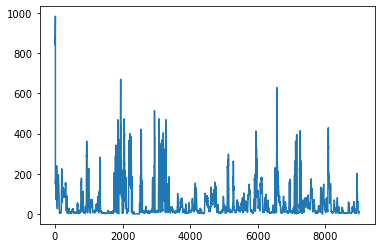

Tail_end_movement_M1_median_5 0       843.167366
1       424.133255
2         5.099144
3         3.544440
4         5.099144
           ...    
8995      0.553741
8996      0.489159
8997      0.489159
8998      0.375039
8999      0.375039
Name: Tail_end_movement_M1_median_5, Length: 9000, dtype: float64


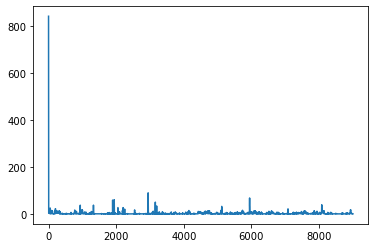

Tail_end_movement_M1_mean_5 0       843.167366
1       424.133255
2       283.068391
3       212.798727
4       172.485276
           ...    
8995      0.577147
8996      0.469729
8997      0.469729
8998      0.339192
8999      0.654832
Name: Tail_end_movement_M1_mean_5, Length: 9000, dtype: float64


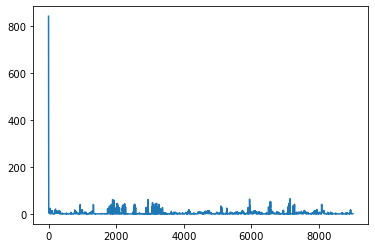

Tail_end_movement_M1_sum_5 0       843.167366
1       848.266509
2       849.205174
3       851.194909
4       862.426382
           ...    
8995      3.462880
8996      2.818375
8997      2.818375
8998      2.035153
8999      3.928990
Name: Tail_end_movement_M1_sum_5, Length: 9000, dtype: float64


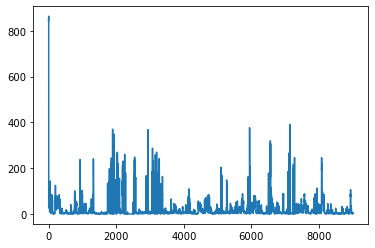

Tail_end_movement_M1_median_6 0       843.167366
1       424.133255
2         5.099144
3         3.544440
4         5.099144
           ...    
8995      0.533920
8996      0.533920
8997      0.444398
8998      0.305681
8999      0.444398
Name: Tail_end_movement_M1_median_6, Length: 9000, dtype: float64


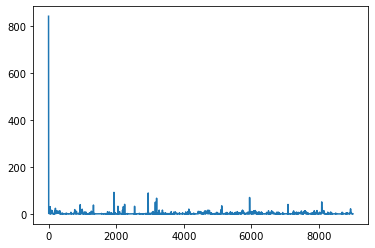

Tail_end_movement_M1_mean_6 0       843.167366
1       424.133255
2       283.068391
3       212.798727
4       172.485276
           ...    
8995      0.474795
8996      0.563675
8997      0.345894
8998      0.292318
8999      0.750279
Name: Tail_end_movement_M1_mean_6, Length: 9000, dtype: float64


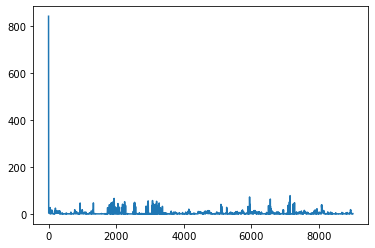

Tail_end_movement_M1_sum_6 0       843.167366
1       848.266509
2       849.205174
3       851.194909
4       862.426382
           ...    
8995      2.373977
8996      2.818375
8997      1.729472
8998      1.461592
8999      3.751397
Name: Tail_end_movement_M1_sum_6, Length: 9000, dtype: float64


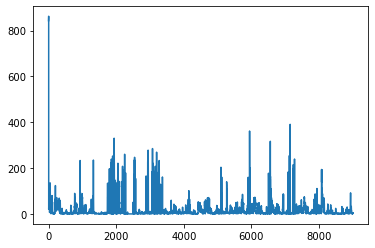

Tail_end_movement_M1_median_7.5 0       843.167366
1       424.133255
2         5.099144
3         3.544440
4         3.544440
           ...    
8995      0.553741
8996      0.489159
8997      0.310996
8998      0.375039
8999      0.375039
Name: Tail_end_movement_M1_median_7.5, Length: 9000, dtype: float64


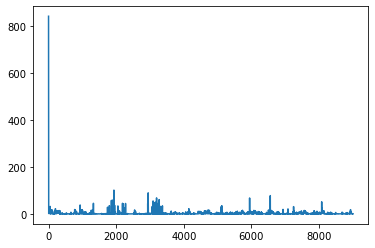

Tail_end_movement_M1_mean_7.5 0       843.167366
1       424.133255
2       283.068391
3       212.798727
4         4.814754
           ...    
8995      0.593494
8996      0.432368
8997      0.288978
8998      0.321000
8999      0.804369
Name: Tail_end_movement_M1_mean_7.5, Length: 9000, dtype: float64


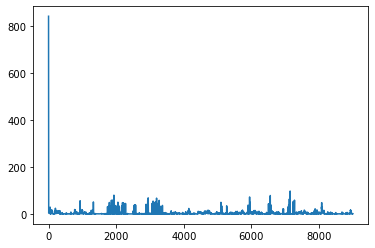

Tail_end_movement_M1_sum_7.5 0       843.167366
1       848.266509
2       849.205174
3       851.194909
4        19.259016
           ...    
8995      2.373977
8996      1.729472
8997      1.155911
8998      1.283999
8999      3.217477
Name: Tail_end_movement_M1_sum_7.5, Length: 9000, dtype: float64


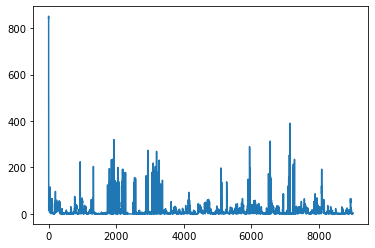

Tail_end_movement_M1_median_15 0       843.167366
1       424.133255
2         3.018904
3         1.464200
4         6.610604
           ...    
8995      0.355757
8996      0.489159
8997      0.222199
8998      0.152841
8999      1.386539
Name: Tail_end_movement_M1_median_15, Length: 9000, dtype: float64


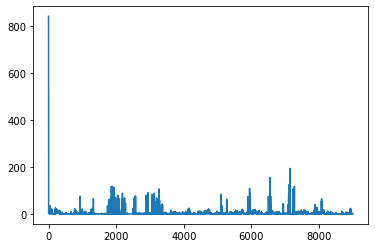

Tail_end_movement_M1_mean_15 0       843.167366
1       424.133255
2         3.018904
3         1.464200
4         6.610604
           ...    
8995      0.355757
8996      0.489159
8997      0.222199
8998      0.152841
8999      1.386539
Name: Tail_end_movement_M1_mean_15, Length: 9000, dtype: float64


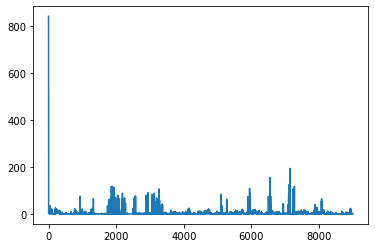

Tail_end_movement_M1_sum_15 0       843.167366
1       848.266509
2         6.037808
3         2.928400
4        13.221208
           ...    
8995      0.711514
8996      0.978318
8997      0.444398
8998      0.305681
8999      2.773079
Name: Tail_end_movement_M1_sum_15, Length: 9000, dtype: float64


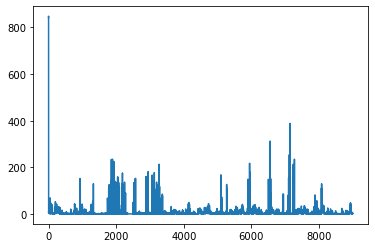

Nose_movement_M1_median_2 0       1041.349366
1        528.291518
2         19.076021
3         17.154845
4         19.076021
           ...     
8995       4.510017
8996       4.510017
8997       4.510017
8998       4.510017
8999       3.587249
Name: Nose_movement_M1_median_2, Length: 9000, dtype: float64


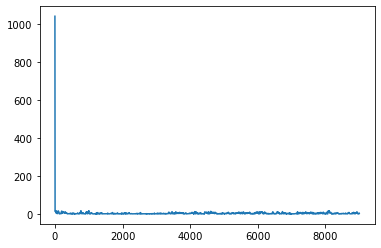

Nose_movement_M1_mean_2 0       1041.349366
1        528.291518
2        358.553019
3        270.680391
4        220.510820
           ...     
8995       5.757775
8996       5.825344
8997       5.832097
8998       5.804930
8999       5.022039
Name: Nose_movement_M1_mean_2, Length: 9000, dtype: float64


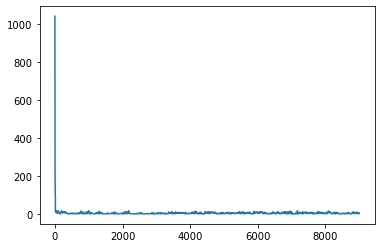

Nose_movement_M1_sum_2 0       1041.349366
1       1056.583035
2       1075.659056
3       1082.721565
4       1102.554098
           ...     
8995      86.366630
8996      87.380153
8997      87.481462
8998      87.073947
8999      75.330590
Name: Nose_movement_M1_sum_2, Length: 9000, dtype: float64


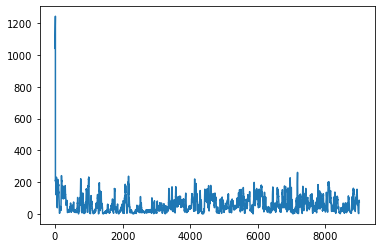

Nose_movement_M1_median_5 0       1041.349366
1        528.291518
2         19.076021
3         17.154845
4         19.076021
           ...     
8995       3.334681
8996       3.334681
8997       3.334681
8998       2.069337
8999       1.106547
Name: Nose_movement_M1_median_5, Length: 9000, dtype: float64


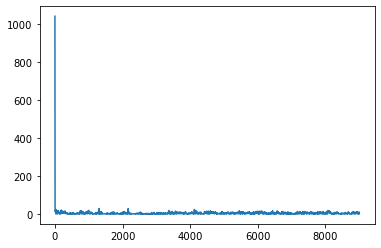

Nose_movement_M1_mean_5 0       1041.349366
1        528.291518
2        358.553019
3        270.680391
4        220.510820
           ...     
8995       3.257454
8996       3.180234
8997       2.905208
8998       2.307333
8999       1.748419
Name: Nose_movement_M1_mean_5, Length: 9000, dtype: float64


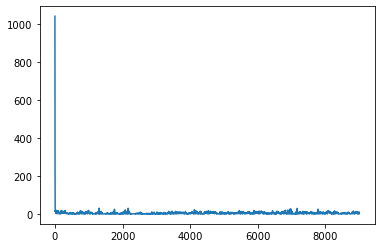

Nose_movement_M1_sum_5 0       1041.349366
1       1056.583035
2       1075.659056
3       1082.721565
4       1102.554098
           ...     
8995      19.544727
8996      19.081401
8997      17.431246
8998      13.843997
8999      10.490514
Name: Nose_movement_M1_sum_5, Length: 9000, dtype: float64


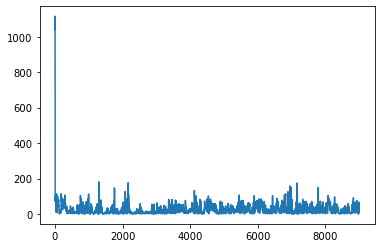

Nose_movement_M1_median_6 0       1041.349366
1        528.291518
2         19.076021
3         17.154845
4         19.076021
           ...     
8995       3.587249
8996       3.587249
8997       3.082113
8998       1.056560
8999       1.056560
Name: Nose_movement_M1_median_6, Length: 9000, dtype: float64


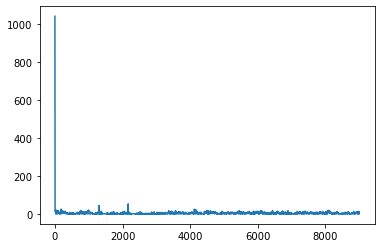

Nose_movement_M1_mean_6 0       1041.349366
1        528.291518
2        358.553019
3        270.680391
4        220.510820
           ...     
8995       3.604968
8996       3.452430
8997       2.768799
8998       1.866796
8999       1.092861
Name: Nose_movement_M1_mean_6, Length: 9000, dtype: float64


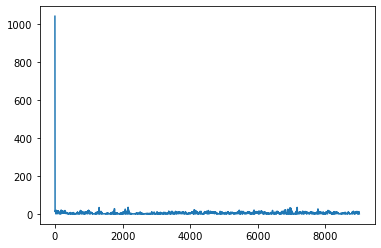

Nose_movement_M1_sum_6 0       1041.349366
1       1056.583035
2       1075.659056
3       1082.721565
4       1102.554098
           ...     
8995      18.024841
8996      17.262149
8997      13.843997
8998       9.333980
8999       5.464303
Name: Nose_movement_M1_sum_6, Length: 9000, dtype: float64


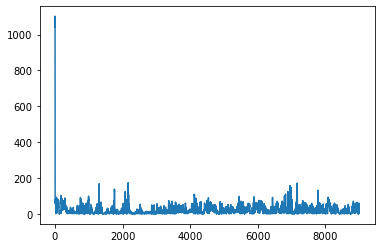

Nose_movement_M1_median_7.5 0       1041.349366
1        528.291518
2         19.076021
3         17.154845
4         17.154845
           ...     
8995       4.048633
8996       3.796065
8997       2.069337
8998       0.612828
8999       0.612828
Name: Nose_movement_M1_median_7.5, Length: 9000, dtype: float64


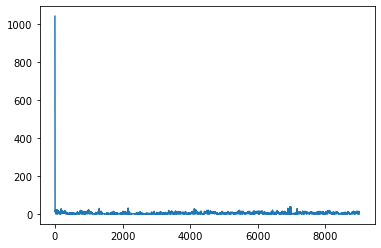

Nose_movement_M1_mean_7.5 0       1041.349366
1        528.291518
2        358.553019
3        270.680391
4         15.301183
           ...     
8995       4.051397
8996       3.418725
8997       2.333495
8998       1.076943
8999       0.595547
Name: Nose_movement_M1_mean_7.5, Length: 9000, dtype: float64


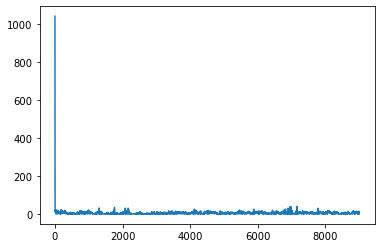

Nose_movement_M1_sum_7.5 0       1041.349366
1       1056.583035
2       1075.659056
3       1082.721565
4         61.204732
           ...     
8995      16.205589
8996      13.674901
8997       9.333980
8998       4.307770
8999       2.382190
Name: Nose_movement_M1_sum_7.5, Length: 9000, dtype: float64


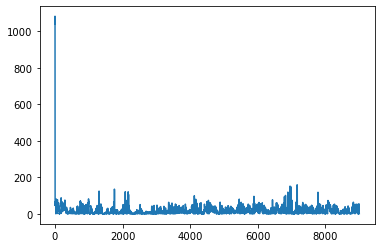

Nose_movement_M1_median_15 0       1041.349366
1        528.291518
2         17.154845
3         13.069265
4         13.447521
           ...     
8995       4.054162
8996       2.069337
8997       0.612828
8998       0.084548
8999       0.578267
Name: Nose_movement_M1_median_15, Length: 9000, dtype: float64


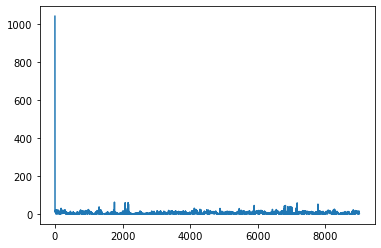

Nose_movement_M1_mean_15 0       1041.349366
1        528.291518
2         17.154845
3         13.069265
4         13.447521
           ...     
8995       4.054162
8996       2.069337
8997       0.612828
8998       0.084548
8999       0.578267
Name: Nose_movement_M1_mean_15, Length: 9000, dtype: float64


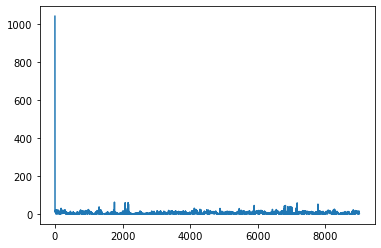

Nose_movement_M1_sum_15 0       1041.349366
1       1056.583035
2         34.309690
3         26.138530
4         26.895042
           ...     
8995       8.108324
8996       4.138673
8997       1.225657
8998       0.169097
8999       1.156533
Name: Nose_movement_M1_sum_15, Length: 9000, dtype: float64


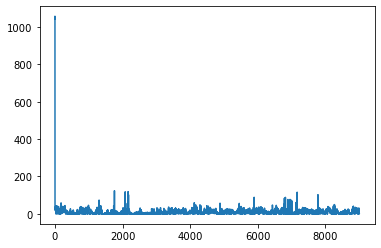

Total_movement_M1_median_2 0       7754.146518
1       3913.194056
2        101.323295
3         86.782444
4         89.573178
           ...     
8995      14.162052
8996      14.162052
8997      14.162052
8998      14.162052
8999      13.959663
Name: Total_movement_M1_median_2, Length: 9000, dtype: float64


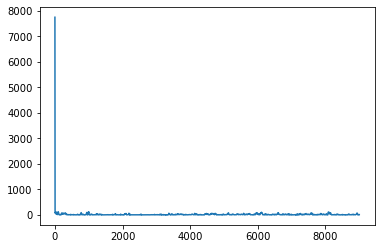

Total_movement_M1_mean_2 0       7754.146518
1       3913.194056
2       2642.570469
3       1995.142785
4       1614.028864
           ...     
8995      15.204637
8996      15.063203
8997      15.092653
8998      15.089486
8999      14.166887
Name: Total_movement_M1_mean_2, Length: 9000, dtype: float64


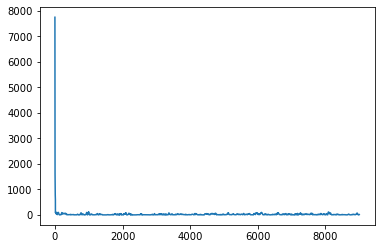

Total_movement_M1_sum_2 0       7754.146518
1       7826.388112
2       7927.711407
3       7980.571141
4       8070.144319
           ...     
8995     228.069549
8996     225.948043
8997     226.389791
8998     226.342296
8999     212.503305
Name: Total_movement_M1_sum_2, Length: 9000, dtype: float64


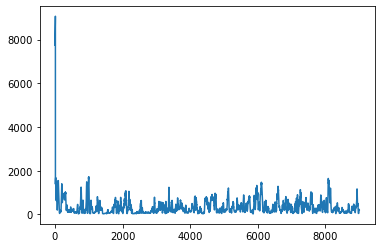

Total_movement_M1_median_5 0       7754.146518
1       3913.194056
2        101.323295
3         86.782444
4         89.573178
           ...     
8995      14.229480
8996      12.564367
8997      12.564367
8998       7.138812
8999       4.787542
Name: Total_movement_M1_median_5, Length: 9000, dtype: float64


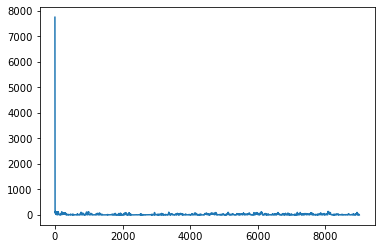

Total_movement_M1_mean_5 0       7754.146518
1       3913.194056
2       2642.570469
3       1995.142785
4       1614.028864
           ...     
8995      13.356703
8996      11.570661
8997      10.718458
8998       8.702796
8999       6.658600
Name: Total_movement_M1_mean_5, Length: 9000, dtype: float64


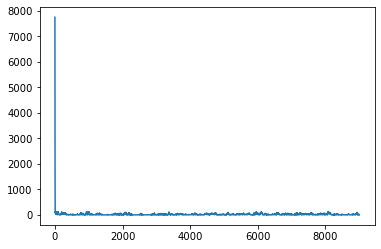

Total_movement_M1_sum_5 0       7754.146518
1       7826.388112
2       7927.711407
3       7980.571141
4       8070.144319
           ...     
8995      80.140220
8996      69.423965
8997      64.310750
8998      52.216775
8999      39.951601
Name: Total_movement_M1_sum_5, Length: 9000, dtype: float64


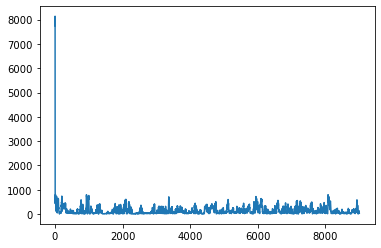

Total_movement_M1_median_6 0       7754.146518
1       3913.194056
2        101.323295
3         86.782444
4         89.573178
           ...     
8995      14.296908
8996      14.296908
8997      10.831827
8998       3.445797
8999       3.445797
Name: Total_movement_M1_median_6, Length: 9000, dtype: float64


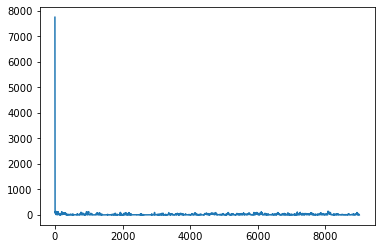

Total_movement_M1_mean_6 0       7754.146518
1       3913.194056
2       2642.570469
3       1995.142785
4       1614.028864
           ...     
8995      13.195634
8996      12.497985
8997       9.757963
8998       6.764463
8999       5.130939
Name: Total_movement_M1_mean_6, Length: 9000, dtype: float64


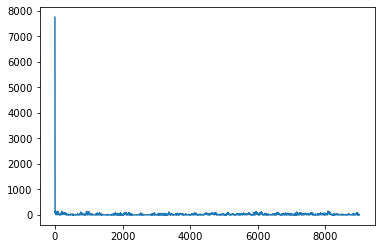

Total_movement_M1_sum_6 0       7754.146518
1       7826.388112
2       7927.711407
3       7980.571141
4       8070.144319
           ...     
8995      65.978168
8996      62.489927
8997      48.789816
8998      33.822314
8999      25.654694
Name: Total_movement_M1_sum_6, Length: 9000, dtype: float64


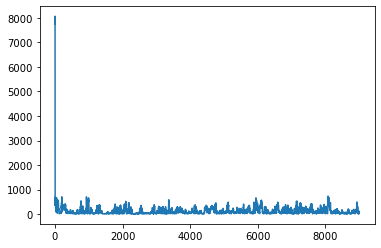

Total_movement_M1_median_7.5 0       7754.146518
1       3913.194056
2        101.323295
3         86.782444
4         80.907386
           ...     
8995      14.908921
8996      12.564367
8997       7.138812
8998       3.436378
8999       3.436378
Name: Total_movement_M1_median_7.5, Length: 9000, dtype: float64


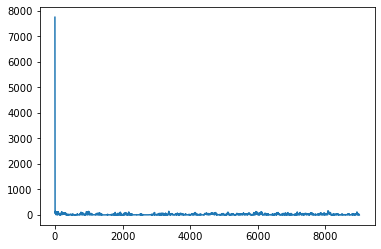

Total_movement_M1_mean_7.5 0       7754.146518
1       3913.194056
2       2642.570469
3       1995.142785
4         78.999450
           ...     
8995      14.761032
8996      11.742248
8997       7.598839
8998       4.881352
8999       3.705717
Name: Total_movement_M1_mean_7.5, Length: 9000, dtype: float64


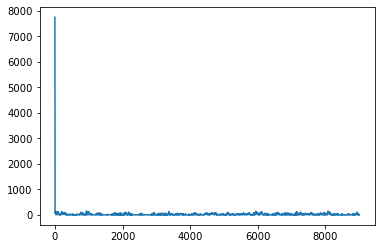

Total_movement_M1_sum_7.5 0       7754.146518
1       7826.388112
2       7927.711407
3       7980.571141
4        315.997801
           ...     
8995      59.044130
8996      46.968992
8997      30.395355
8998      19.525406
8999      14.822867
Name: Total_movement_M1_sum_7.5, Length: 9000, dtype: float64


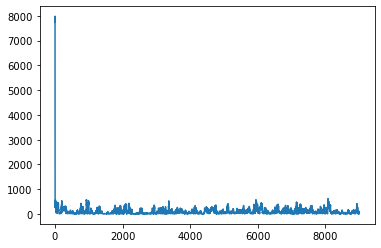

Total_movement_M1_median_15 0       7754.146518
1       3913.194056
2         86.782444
3         77.091515
4         71.216456
           ...     
8995      12.564367
8996       7.138812
8997       2.633310
8998       2.623891
8999       4.778123
Name: Total_movement_M1_median_15, Length: 9000, dtype: float64


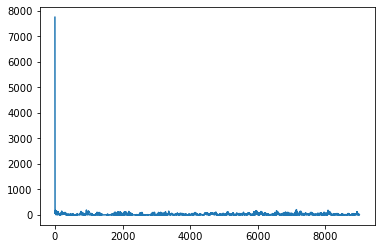

Total_movement_M1_mean_15 0       7754.146518
1       3913.194056
2         86.782444
3         77.091515
4         71.216456
           ...     
8995      12.564367
8996       7.138812
8997       2.633310
8998       2.623891
8999       4.778123
Name: Total_movement_M1_mean_15, Length: 9000, dtype: float64


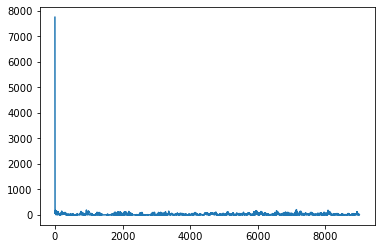

Total_movement_M1_sum_15 0       7754.146518
1       7826.388112
2        173.564889
3        154.183030
4        142.432912
           ...     
8995      25.128734
8996      14.277624
8997       5.266620
8998       5.247782
8999       9.556247
Name: Total_movement_M1_sum_15, Length: 9000, dtype: float64


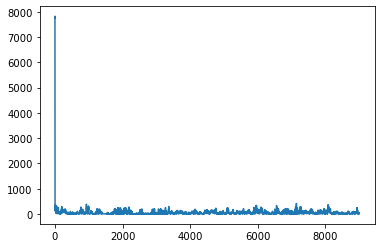

Tail_end_relative_to_tail_base_centroid_nose 0      -2098.098314
1        -25.780043
2        -36.058904
3        -16.080643
4        -21.239691
           ...     
8995      -3.836499
8996      -1.247600
8997      -0.852059
8998      -0.414026
8999       1.018283
Name: Tail_end_relative_to_tail_base_centroid_nose, Length: 9000, dtype: float64


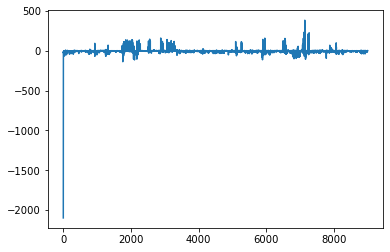

Tail_end_relative_to_tail_base_centroid_nose_M1_2 0      -2098.098314
1      -1061.939178
2       -719.979087
3       -544.004476
4       -439.451519
           ...     
8995      -6.770937
8996      -6.632288
8997      -6.664503
8998      -6.569799
8999      -5.578038
Name: Tail_end_relative_to_tail_base_centroid_nose_M1_2, Length: 9000, dtype: float64


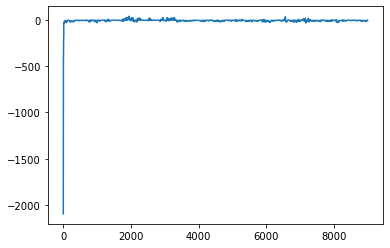

Tail_end_relative_to_tail_base_centroid_nose_M1_5 0      -2098.098314
1      -1061.939178
2       -719.979087
3       -544.004476
4       -439.451519
           ...     
8995      -4.339472
8996      -3.960242
8997      -3.623606
8998      -2.976793
8999      -1.938852
Name: Tail_end_relative_to_tail_base_centroid_nose_M1_5, Length: 9000, dtype: float64


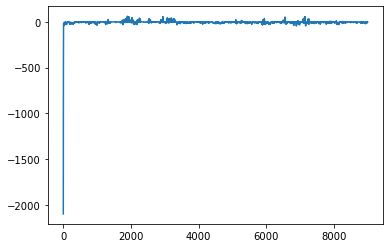

Tail_end_relative_to_tail_base_centroid_nose_M1_6 0      -2098.098314
1      -1061.939178
2       -719.979087
3       -544.004476
4       -439.451519
           ...     
8995      -4.502771
8996      -4.177915
8997      -3.489347
8998      -2.530279
8999      -1.066380
Name: Tail_end_relative_to_tail_base_centroid_nose_M1_6, Length: 9000, dtype: float64


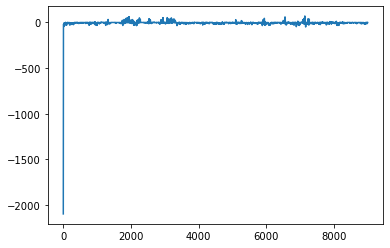

Tail_end_relative_to_tail_base_centroid_nose_M1_7.5 0      -2098.098314
1      -1061.939178
2       -719.979087
3       -544.004476
4        -24.789820
           ...     
8995      -4.910494
8996      -4.148669
8997      -3.059343
8998      -1.587546
8999      -0.373850
Name: Tail_end_relative_to_tail_base_centroid_nose_M1_7.5, Length: 9000, dtype: float64


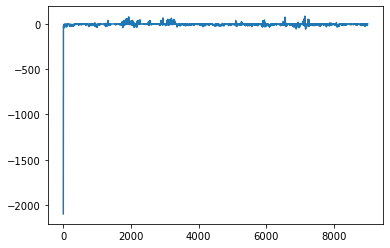

Tail_end_relative_to_tail_base_centroid_nose_M1_15 0      -2098.098314
1      -1061.939178
2        -30.919474
3        -26.069774
4        -18.660167
           ...     
8995      -5.068856
8996      -2.542050
8997      -1.049829
8998      -0.633042
8999       0.302129
Name: Tail_end_relative_to_tail_base_centroid_nose_M1_15, Length: 9000, dtype: float64


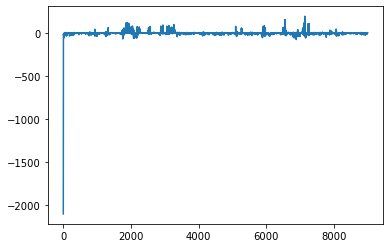

Mouse_angle 0        97.346472
1        97.877307
2       103.210775
3       106.462184
4       110.568257
           ...    
8995    108.156424
8996    108.359514
8997    108.376879
8998    108.396691
8999    108.333389
Name: Mouse_angle, Length: 9000, dtype: float64


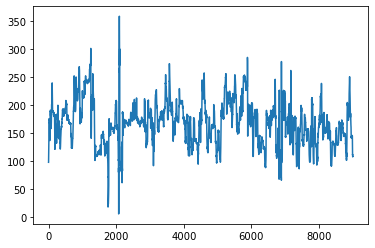

Total_movement_all_bodyparts_deviation 0      -7731.596909
1        -49.691984
2        -78.773686
3        -30.310125
4        -67.023569
           ...     
8995      11.717783
8996      19.103812
8997      20.728786
8998      19.122650
8999      16.420322
Name: Total_movement_all_bodyparts_deviation, Length: 9000, dtype: float64


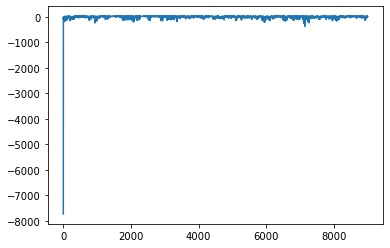

M1_smallest_euclid_distances_hull_deviation 0      -3.950863
1      -4.170487
2      -5.881342
3      -3.532288
4      -3.852818
          ...   
8995   -0.423061
8996   -0.423061
8997   -1.727576
8998   -0.423061
8999   -0.423061
Name: M1_smallest_euclid_distances_hull_deviation, Length: 9000, dtype: float64


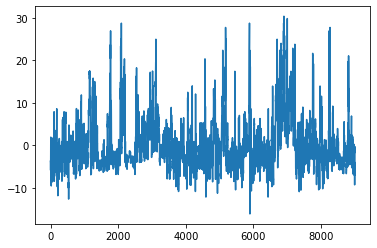

M1_largest_euclid_distances_hull_deviation 0       44.109082
1       36.570794
2       23.943227
3       21.709057
4        5.470867
          ...    
8995    22.501778
8996    22.501778
8997    21.626709
8998    21.626709
8999    22.612192
Name: M1_largest_euclid_distances_hull_deviation, Length: 9000, dtype: float64


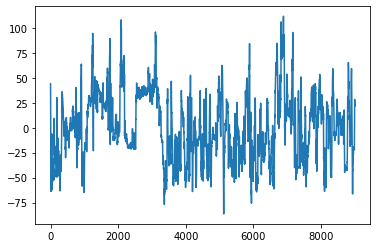

M1_mean_euclid_distances_hull_deviation 0       12.924965
1       10.740025
2        3.444836
3        1.248877
4       -5.440049
          ...    
8995     5.254120
8996     5.265110
8997     5.020609
8998     5.015489
8999     5.290480
Name: M1_mean_euclid_distances_hull_deviation, Length: 9000, dtype: float64


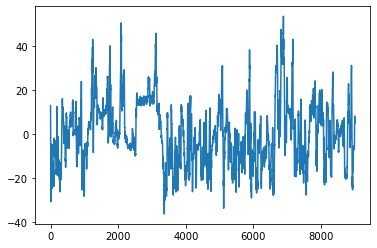

Total_angle_deviation 0       70.848999
1       70.318164
2       64.984696
3       61.733287
4       57.627214
          ...    
8995    60.039046
8996    59.835957
8997    59.818592
8998    59.798780
8999    59.862082
Name: Total_angle_deviation, Length: 9000, dtype: float64


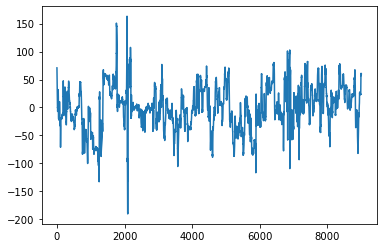

Movement_mouse_deviation_centroid 0      -985.073473
1        -6.662081
2       -15.645039
3        -5.097453
4        -9.916244
           ...    
8995      1.211433
8996      1.620614
8997      2.109510
8998      1.751997
8999      2.052129
Name: Movement_mouse_deviation_centroid, Length: 9000, dtype: float64


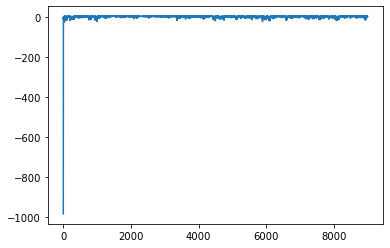

Mouse_polygon_deviation 0       44.071219
1       32.467760
2        2.673532
3       -3.205215
4      -29.749528
          ...    
8995    12.723536
8996    10.944472
8997     9.901662
8998     8.352387
8999     9.855008
Name: Mouse_polygon_deviation, Length: 9000, dtype: float64


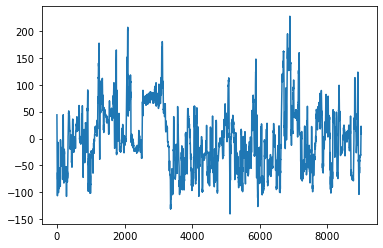

Mouse1_smallest_euclid_distances_mean_2_deviation 0      -3.949845
1      -4.059656
2      -4.666545
3      -4.382726
4      -4.276541
          ...   
8995   -3.709882
8996   -3.722596
8997   -3.822277
8998   -3.834991
8999   -3.769005
Name: Mouse1_smallest_euclid_distances_mean_2_deviation, Length: 9000, dtype: float64


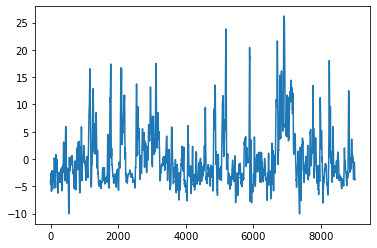

Mouse1_smallest_euclid_distances_mean_5_deviation 0      -3.949886
1      -4.059697
2      -4.666587
3      -4.382768
4      -4.276582
          ...   
8995   -4.416386
8996   -3.372645
8997   -2.106703
8998   -1.074341
8999   -0.856922
Name: Mouse1_smallest_euclid_distances_mean_5_deviation, Length: 9000, dtype: float64


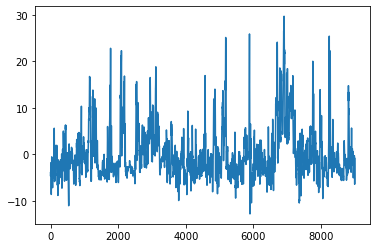

Mouse1_smallest_euclid_distances_mean_6_deviation 0      -3.950089
1      -4.059900
2      -4.666789
3      -4.382970
4      -4.276785
          ...   
8995   -3.962961
8996   -2.182927
8997   -1.204995
8998   -0.944092
8999   -0.683189
Name: Mouse1_smallest_euclid_distances_mean_6_deviation, Length: 9000, dtype: float64


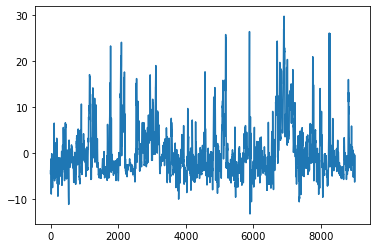

Mouse1_smallest_euclid_distances_mean_7.5_deviation 0      -3.950286
1      -4.060097
2      -4.666986
3      -4.383167
4      -4.358656
          ...   
8995   -2.623284
8996   -1.074741
8997   -1.074741
8998   -0.748612
8999   -0.748612
Name: Mouse1_smallest_euclid_distances_mean_7.5_deviation, Length: 9000, dtype: float64


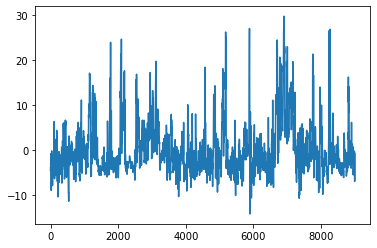

Mouse1_smallest_euclid_distances_mean_15_deviation 0      -3.950667
1      -4.060479
2      -5.025718
3      -4.706619
4      -3.692357
          ...   
8995   -1.075123
8996   -0.422865
8997   -1.075123
8998   -1.075123
8999   -0.422865
Name: Mouse1_smallest_euclid_distances_mean_15_deviation, Length: 9000, dtype: float64


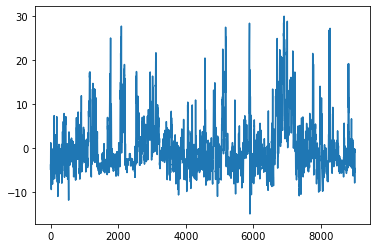

Mouse1_largest_euclid_distances_mean_2_deviation 0       44.107937
1       40.338793
2       34.873223
3       31.581895
4       26.359460
          ...    
8995     9.942214
8996    12.871846
8997    15.743140
8998    18.656126
8999    21.077283
Name: Mouse1_largest_euclid_distances_mean_2_deviation, Length: 9000, dtype: float64


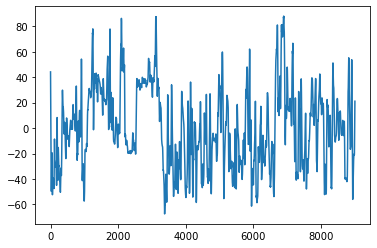

Mouse1_largest_euclid_distances_mean_5_deviation 0       44.104562
1       40.335418
2       34.869847
3       31.578520
4       26.356085
          ...    
8995    25.478951
8996    24.992491
8997    24.443453
8998    23.661722
8999    22.716990
Name: Mouse1_largest_euclid_distances_mean_5_deviation, Length: 9000, dtype: float64


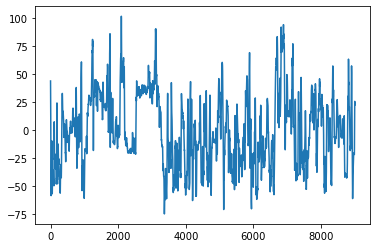

Mouse1_largest_euclid_distances_mean_6_deviation 0       44.105133
1       40.335989
2       34.870419
3       31.579091
4       26.356656
          ...    
8995    25.492109
8996    25.008277
8997    24.070200
8998    22.739425
8999    22.169884
Name: Mouse1_largest_euclid_distances_mean_6_deviation, Length: 9000, dtype: float64


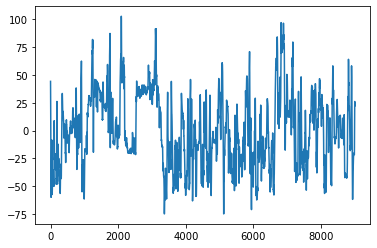

Mouse1_largest_euclid_distances_mean_7.5_deviation 0       44.105883
1       40.336739
2       34.871169
3       31.579841
4       21.920287
          ...    
8995    25.636639
8996    24.682810
8997    23.019341
8998    22.061044
8999    22.088648
Name: Mouse1_largest_euclid_distances_mean_7.5_deviation, Length: 9000, dtype: float64


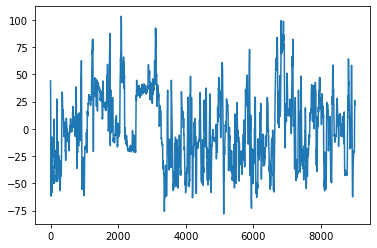

Mouse1_largest_euclid_distances_mean_15_deviation 0       44.107888
1       40.338744
2       30.255816
3       22.824948
4       13.588768
          ...    
8995    23.979644
8996    22.500584
8997    22.063049
8998    21.625514
8999    22.118256
Name: Mouse1_largest_euclid_distances_mean_15_deviation, Length: 9000, dtype: float64


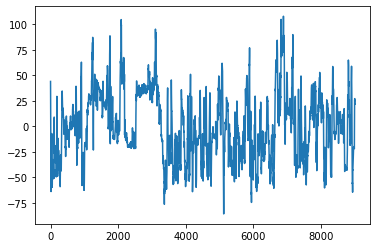

Mouse1_mean_euclid_distances_mean_2_deviation 0       12.926274
1       11.833803
2        9.037917
3        7.090984
4        4.585039
          ...    
8995     2.466486
8996     3.246015
8997     3.996129
8998     4.762592
8999     5.427844
Name: Mouse1_mean_euclid_distances_mean_2_deviation, Length: 9000, dtype: float64


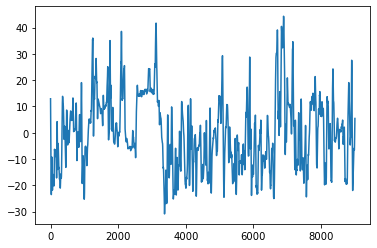

Mouse1_mean_euclid_distances_mean_5_deviation 0       12.923475
1       11.831005
2        9.035118
3        7.088186
4        4.582241
          ...    
8995     7.228268
8996     6.795625
8997     6.340329
8998     5.824749
8999     5.350938
Name: Mouse1_mean_euclid_distances_mean_5_deviation, Length: 9000, dtype: float64


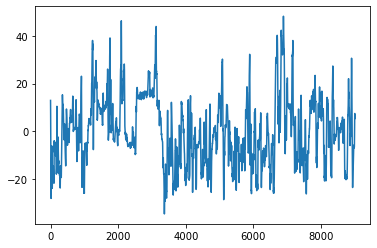

Mouse1_mean_euclid_distances_mean_6_deviation 0       12.923613
1       11.831143
2        9.035256
3        7.088324
4        4.582379
          ...    
8995     7.102164
8996     6.604708
8997     5.987037
8998     5.363466
8999     5.167809
Name: Mouse1_mean_euclid_distances_mean_6_deviation, Length: 9000, dtype: float64


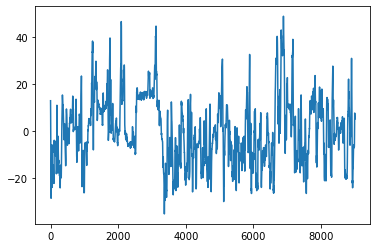

Mouse1_mean_euclid_distances_mean_7.5_deviation 0       12.923839
1       11.831368
2        9.035482
3        7.088549
4        2.497296
          ...    
8995     6.940172
8996     6.229208
8997     5.451024
8998     5.137706
8999     5.146796
Name: Mouse1_mean_euclid_distances_mean_7.5_deviation, Length: 9000, dtype: float64


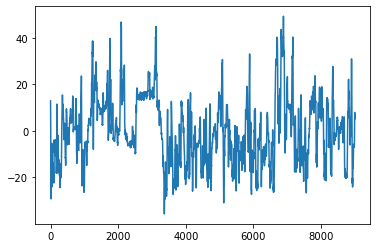

Mouse1_mean_euclid_distances_mean_15_deviation 0       12.924541
1       11.832071
2        7.092006
3        2.346433
4       -2.096010
          ...    
8995     5.761016
8996     5.259191
8997     5.142435
8998     5.017625
8999     5.152560
Name: Mouse1_mean_euclid_distances_mean_15_deviation, Length: 9000, dtype: float64


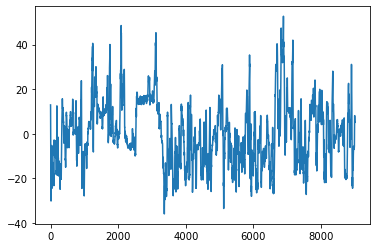

Movement_mouse_percentile_rank 0       1.000000
1       0.956444
2       0.995444
3       0.935778
4       0.978222
          ...   
8995    0.535444
8996    0.376333
8997    0.034278
8998    0.307556
8999    0.108556
Name: Movement_mouse_percentile_rank, Length: 9000, dtype: float64


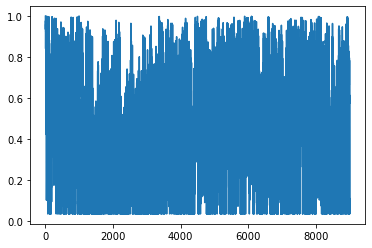

Movement_mouse_deviation_percentile_rank 0       0.000111
1       0.043667
2       0.004667
3       0.064333
4       0.021889
          ...   
8995    0.464667
8996    0.623778
8997    0.965833
8998    0.692556
8999    0.891556
Name: Movement_mouse_deviation_percentile_rank, Length: 9000, dtype: float64


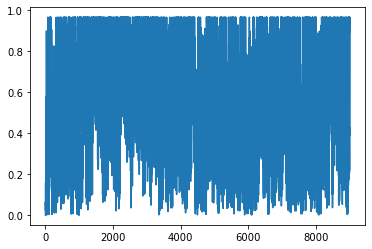

Total_movement_M1_mean_2_percentile_rank 0      -7729.566220
1      -3888.613758
2      -2617.990171
3      -1970.562488
4      -1589.448566
           ...     
8995       9.375661
8996       9.517095
8997       9.487645
8998       9.490811
8999      10.413411
Name: Total_movement_M1_mean_2_percentile_rank, Length: 9000, dtype: float64


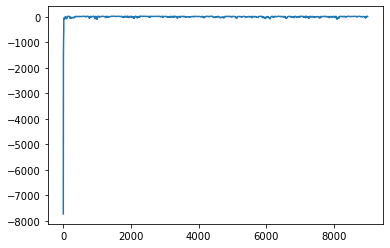

Total_movement_M1_mean_5_percentile_rank 0      -7730.339724
1      -3889.387262
2      -2618.763675
3      -1971.335991
4      -1590.222070
           ...     
8995      10.450091
8996      12.236133
8997      13.088336
8998      15.103998
8999      17.148194
Name: Total_movement_M1_mean_5_percentile_rank, Length: 9000, dtype: float64


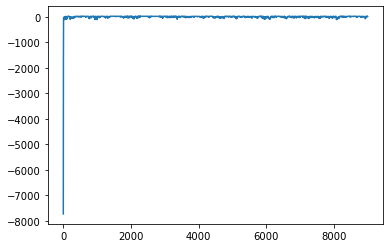

Total_movement_M1_mean_6_percentile_rank 0      -7730.485919
1      -3889.533456
2      -2618.909870
3      -1971.482186
4      -1590.368264
           ...     
8995      10.464966
8996      11.162614
8997      13.902636
8998      16.896137
8999      18.529661
Name: Total_movement_M1_mean_6_percentile_rank, Length: 9000, dtype: float64


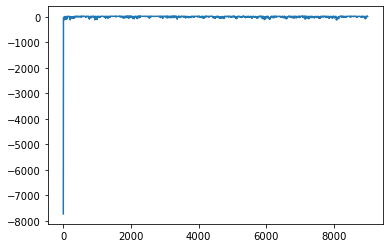

Total_movement_M1_mean_7.5_percentile_rank 0      -7730.660678
1      -3889.708215
2      -2619.084628
3      -1971.656945
4        -55.513610
           ...     
8995       8.724808
8996      11.743593
8997      15.887002
8998      18.604489
8999      19.780124
Name: Total_movement_M1_mean_7.5_percentile_rank, Length: 9000, dtype: float64


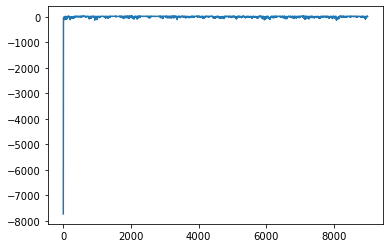

Total_movement_M1_mean_15_percentile_rank 0      -7731.166464
1      -3890.214001
2        -63.802390
3        -54.111460
4        -48.236402
           ...     
8995      10.415687
8996      15.841243
8997      20.346744
8998      20.356163
8999      18.201931
Name: Total_movement_M1_mean_15_percentile_rank, Length: 9000, dtype: float64


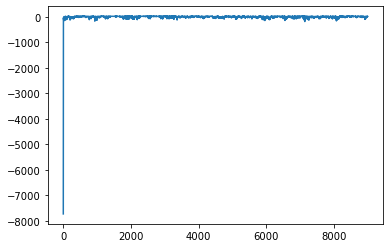

Mouse1_mean_euclid_distances_mean_2_percentile_rank 0       12.926274
1       11.833803
2        9.037917
3        7.090984
4        4.585039
          ...    
8995     2.466486
8996     3.246015
8997     3.996129
8998     4.762592
8999     5.427844
Name: Mouse1_mean_euclid_distances_mean_2_percentile_rank, Length: 9000, dtype: float64


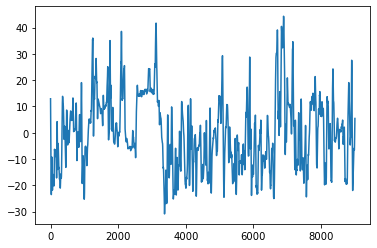

Mouse1_mean_euclid_distances_mean_5_percentile_rank 0       12.923475
1       11.831005
2        9.035118
3        7.088186
4        4.582241
          ...    
8995     7.228268
8996     6.795625
8997     6.340329
8998     5.824749
8999     5.350938
Name: Mouse1_mean_euclid_distances_mean_5_percentile_rank, Length: 9000, dtype: float64


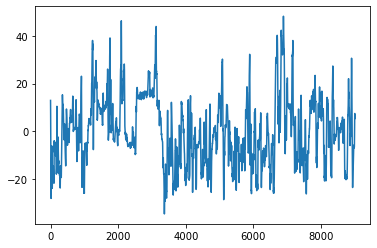

Mouse1_mean_euclid_distances_mean_6_percentile_rank 0       12.923613
1       11.831143
2        9.035256
3        7.088324
4        4.582379
          ...    
8995     7.102164
8996     6.604708
8997     5.987037
8998     5.363466
8999     5.167809
Name: Mouse1_mean_euclid_distances_mean_6_percentile_rank, Length: 9000, dtype: float64


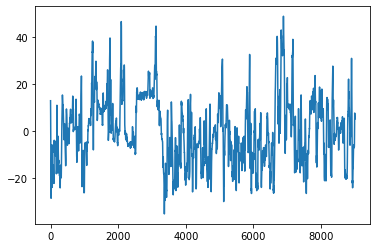

Mouse1_mean_euclid_distances_mean_7.5_percentile_rank 0       12.923839
1       11.831368
2        9.035482
3        7.088549
4        2.497296
          ...    
8995     6.940172
8996     6.229208
8997     5.451024
8998     5.137706
8999     5.146796
Name: Mouse1_mean_euclid_distances_mean_7.5_percentile_rank, Length: 9000, dtype: float64


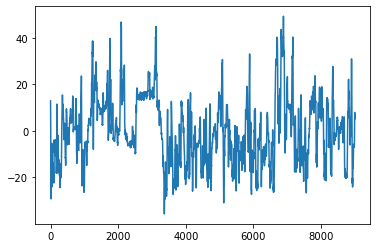

Mouse1_mean_euclid_distances_mean_15_percentile_rank 0       12.924541
1       11.832071
2        7.092006
3        2.346433
4       -2.096010
          ...    
8995     5.761016
8996     5.259191
8997     5.142435
8998     5.017625
8999     5.152560
Name: Mouse1_mean_euclid_distances_mean_15_percentile_rank, Length: 9000, dtype: float64


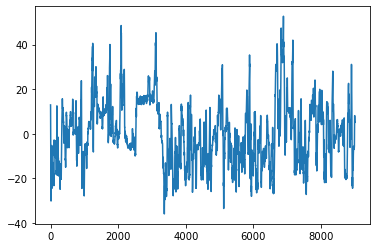

Mouse1_smallest_euclid_distances_mean_2_percentile_rank 0      -3.949845
1      -4.059656
2      -4.666545
3      -4.382726
4      -4.276541
          ...   
8995   -3.709882
8996   -3.722596
8997   -3.822277
8998   -3.834991
8999   -3.769005
Name: Mouse1_smallest_euclid_distances_mean_2_percentile_rank, Length: 9000, dtype: float64


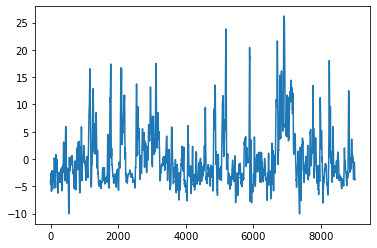

Mouse1_smallest_euclid_distances_mean_5_percentile_rank 0      -3.949886
1      -4.059697
2      -4.666587
3      -4.382768
4      -4.276582
          ...   
8995   -4.416386
8996   -3.372645
8997   -2.106703
8998   -1.074341
8999   -0.856922
Name: Mouse1_smallest_euclid_distances_mean_5_percentile_rank, Length: 9000, dtype: float64


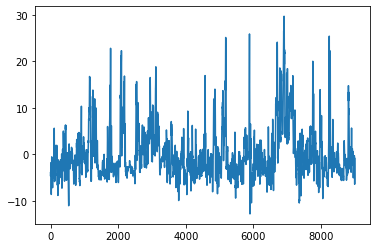

Mouse1_smallest_euclid_distances_mean_6_percentile_rank 0      -3.950089
1      -4.059900
2      -4.666789
3      -4.382970
4      -4.276785
          ...   
8995   -3.962961
8996   -2.182927
8997   -1.204995
8998   -0.944092
8999   -0.683189
Name: Mouse1_smallest_euclid_distances_mean_6_percentile_rank, Length: 9000, dtype: float64


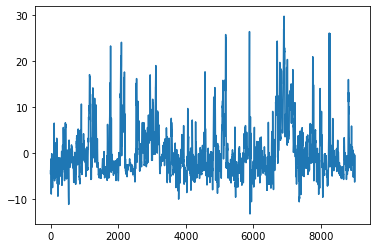

Mouse1_smallest_euclid_distances_mean_7.5_percentile_rank 0      -3.950286
1      -4.060097
2      -4.666986
3      -4.383167
4      -4.358656
          ...   
8995   -2.623284
8996   -1.074741
8997   -1.074741
8998   -0.748612
8999   -0.748612
Name: Mouse1_smallest_euclid_distances_mean_7.5_percentile_rank, Length: 9000, dtype: float64


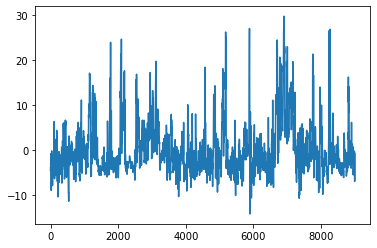

Mouse1_smallest_euclid_distances_mean_15_percentile_rank 0      -3.950667
1      -4.060479
2      -5.025718
3      -4.706619
4      -3.692357
          ...   
8995   -1.075123
8996   -0.422865
8997   -1.075123
8998   -1.075123
8999   -0.422865
Name: Mouse1_smallest_euclid_distances_mean_15_percentile_rank, Length: 9000, dtype: float64


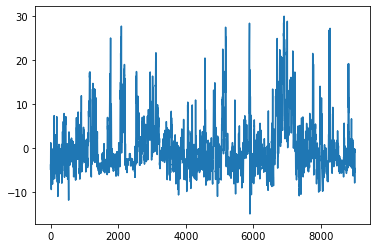

Mouse1_largest_euclid_distances_mean_2_percentile_rank 0       44.107937
1       40.338793
2       34.873223
3       31.581895
4       26.359460
          ...    
8995     9.942214
8996    12.871846
8997    15.743140
8998    18.656126
8999    21.077283
Name: Mouse1_largest_euclid_distances_mean_2_percentile_rank, Length: 9000, dtype: float64


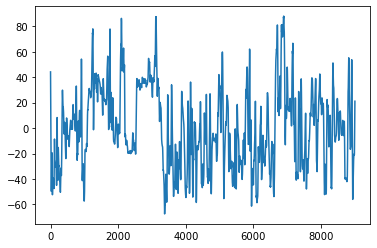

Mouse1_largest_euclid_distances_mean_5_percentile_rank 0       44.104562
1       40.335418
2       34.869847
3       31.578520
4       26.356085
          ...    
8995    25.478951
8996    24.992491
8997    24.443453
8998    23.661722
8999    22.716990
Name: Mouse1_largest_euclid_distances_mean_5_percentile_rank, Length: 9000, dtype: float64


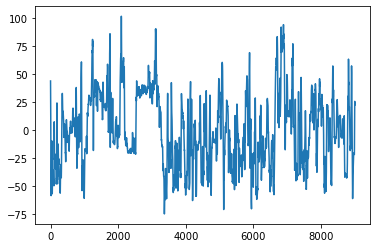

Mouse1_largest_euclid_distances_mean_6_percentile_rank 0       44.105133
1       40.335989
2       34.870419
3       31.579091
4       26.356656
          ...    
8995    25.492109
8996    25.008277
8997    24.070200
8998    22.739425
8999    22.169884
Name: Mouse1_largest_euclid_distances_mean_6_percentile_rank, Length: 9000, dtype: float64


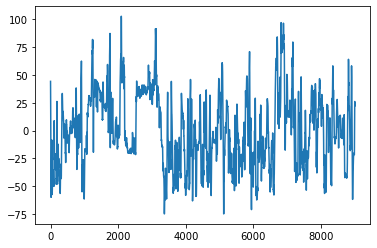

Mouse1_largest_euclid_distances_mean_7.5_percentile_rank 0       44.105883
1       40.336739
2       34.871169
3       31.579841
4       21.920287
          ...    
8995    25.636639
8996    24.682810
8997    23.019341
8998    22.061044
8999    22.088648
Name: Mouse1_largest_euclid_distances_mean_7.5_percentile_rank, Length: 9000, dtype: float64


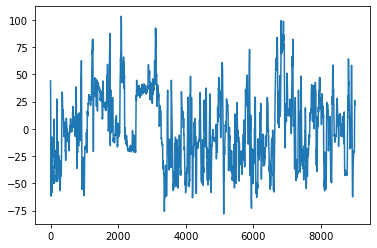

Mouse1_largest_euclid_distances_mean_15_percentile_rank 0       44.107888
1       40.338744
2       30.255816
3       22.824948
4       13.588768
          ...    
8995    23.979644
8996    22.500584
8997    22.063049
8998    21.625514
8999    22.118256
Name: Mouse1_largest_euclid_distances_mean_15_percentile_rank, Length: 9000, dtype: float64


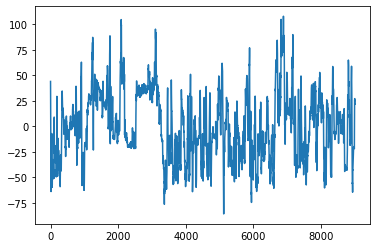

Tortuosity_Mouse1_2 0       60.193496
1       61.389534
2       60.454727
3       58.050645
4       58.246463
          ...    
8995    33.947193
8996    71.619724
8997    37.672531
8998     0.000000
8999     0.000000
Name: Tortuosity_Mouse1_2, Length: 9000, dtype: float64


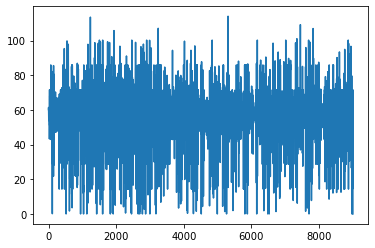

Tortuosity_Mouse1_5 0       149.867992
1       148.466874
2       146.398396
3       143.422436
4       139.842176
           ...    
8995     71.619724
8996     71.619724
8997     37.672531
8998      0.000000
8999      0.000000
Name: Tortuosity_Mouse1_5, Length: 9000, dtype: float64


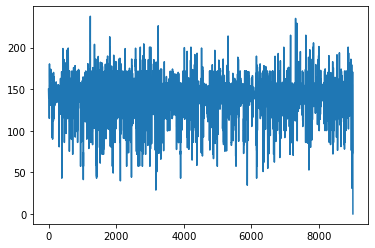

Tortuosity_Mouse1_6 0       178.894686
1       176.164080
2       175.046286
3       168.673053
4       168.909659
           ...    
8995     71.619724
8996     71.619724
8997     37.672531
8998      0.000000
8999      0.000000
Name: Tortuosity_Mouse1_6, Length: 9000, dtype: float64


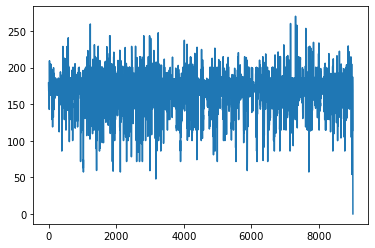

Tortuosity_Mouse1_7.5 0       206.591893
1       204.811970
2       200.296903
3       197.740536
4       197.652155
           ...    
8995     71.619724
8996     71.619724
8997     37.672531
8998      0.000000
8999      0.000000
Name: Tortuosity_Mouse1_7.5, Length: 9000, dtype: float64


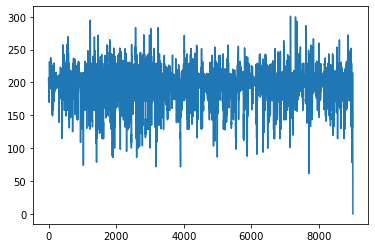

Tortuosity_Mouse1_15 0       436.194869
1       435.115457
2       433.917615
3       432.275699
4       431.878923
           ...    
8995     71.619724
8996     71.619724
8997     37.672531
8998      0.000000
8999      0.000000
Name: Tortuosity_Mouse1_15, Length: 9000, dtype: float64


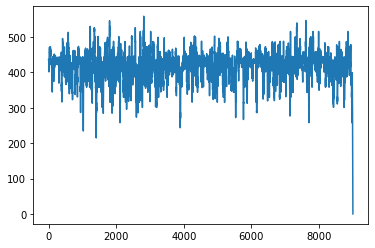

Sum_probabilities 0       7.969298
1       7.976420
2       7.986322
3       7.980574
4       7.984238
          ...   
8995    7.971919
8996    7.970494
8997    7.962785
8998    7.961009
8999    7.966270
Name: Sum_probabilities, Length: 9000, dtype: float64


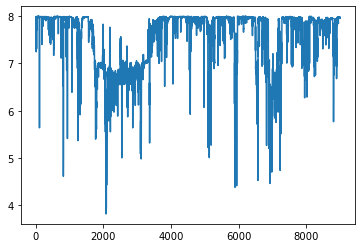

Sum_probabilities_deviation 0      -0.435033
1      -0.442155
2      -0.452057
3      -0.446309
4      -0.449973
          ...   
8995   -0.437653
8996   -0.436229
8997   -0.428520
8998   -0.426744
8999   -0.432005
Name: Sum_probabilities_deviation, Length: 9000, dtype: float64


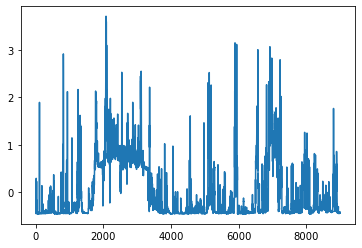

Sum_probabilities_deviation_percentile_rank 0       0.258556
1       0.194222
2       0.061000
3       0.149889
4       0.096667
          ...   
8995    0.238667
8996    0.249889
8997    0.306556
8998    0.319111
8999    0.282000
Name: Sum_probabilities_deviation_percentile_rank, Length: 9000, dtype: float64


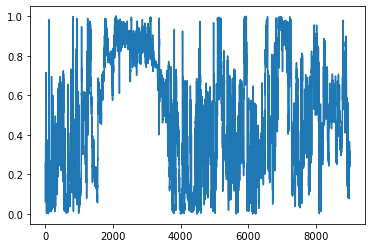

Sum_probabilities_percentile_rank 0       0.258556
1       0.194222
2       0.061000
3       0.149889
4       0.096667
          ...   
8995    0.238667
8996    0.249889
8997    0.306556
8998    0.319111
8999    0.282000
Name: Sum_probabilities_percentile_rank, Length: 9000, dtype: float64


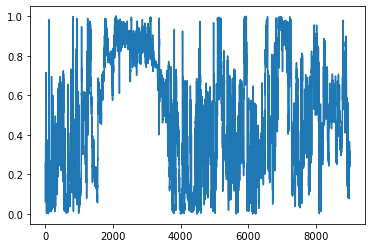

Low_prob_detections_0.1 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Low_prob_detections_0.1, Length: 9000, dtype: int64


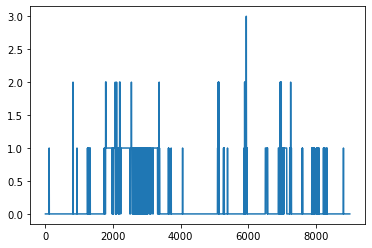

Low_prob_detections_0.5 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Low_prob_detections_0.5, Length: 9000, dtype: int64


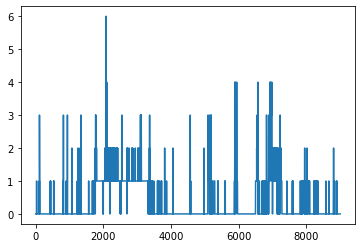

Low_prob_detections_0.75 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Low_prob_detections_0.75, Length: 9000, dtype: int64


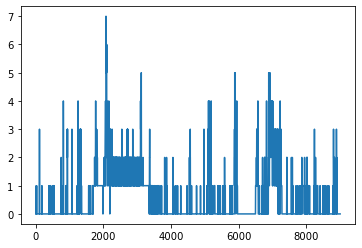

Odour4_Animal_1_in_zone 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour4_Animal_1_in_zone, Length: 9000, dtype: int64


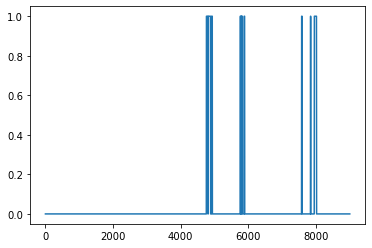

Odour4_Animal_1_distance 0       704.997214
1       697.583039
2       689.293781
3       685.236490
4       672.116397
           ...    
8995    692.394327
8996    692.394327
8997    692.394327
8998    692.394327
8999    693.419302
Name: Odour4_Animal_1_distance, Length: 9000, dtype: float64


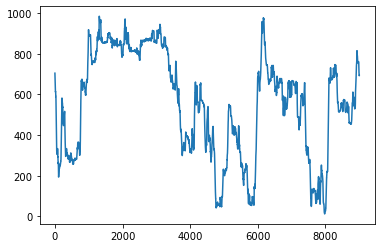

Odour4_Animal_1_facing 0       1
1       1
2       1
3       1
4       1
       ..
8995    1
8996    1
8997    1
8998    1
8999    1
Name: Odour4_Animal_1_facing, Length: 9000, dtype: int64


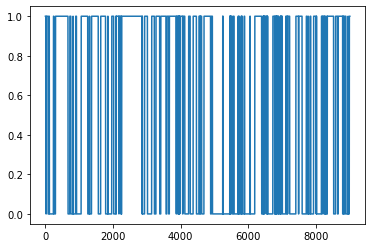

Odour6_Animal_1_in_zone 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour6_Animal_1_in_zone, Length: 9000, dtype: int64


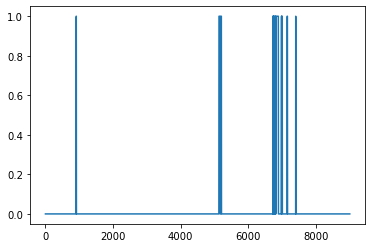

Odour6_Animal_1_distance 0       368.152295
1       352.559938
2       334.400855
3       327.661009
4       307.182796
           ...    
8995    574.972853
8996    574.972853
8997    574.972853
8998    574.972853
8999    576.267379
Name: Odour6_Animal_1_distance, Length: 9000, dtype: float64


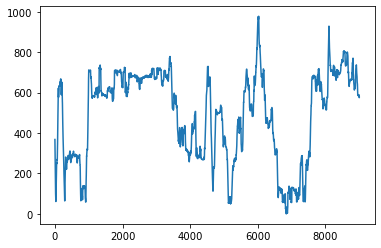

Odour6_Animal_1_facing 0       1
1       1
2       1
3       1
4       1
       ..
8995    1
8996    1
8997    1
8998    1
8999    1
Name: Odour6_Animal_1_facing, Length: 9000, dtype: int64


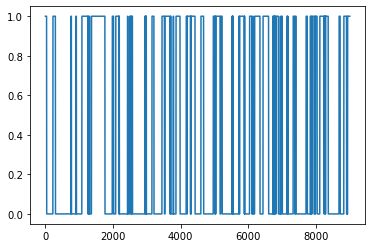

Odour1_Animal_1_in_zone 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour1_Animal_1_in_zone, Length: 9000, dtype: int64


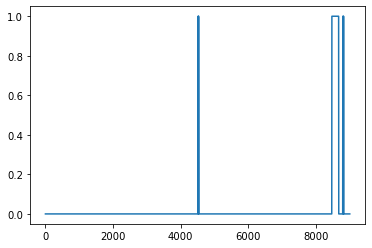

Odour1_Animal_1_distance 0       627.998291
1       633.549043
2       640.460751
3       641.825995
4       645.128979
           ...    
8995    408.607596
8996    408.607596
8997    408.607596
8998    408.607596
8999    408.571250
Name: Odour1_Animal_1_distance, Length: 9000, dtype: float64


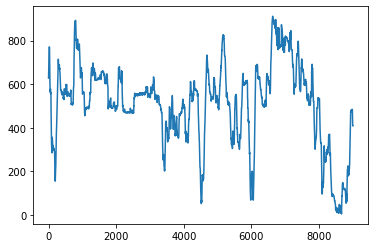

Odour1_Animal_1_facing 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour1_Animal_1_facing, Length: 9000, dtype: int64


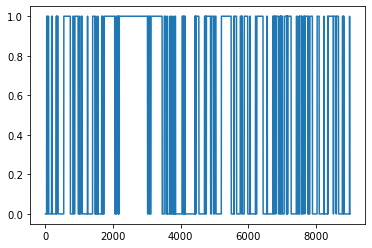

Odour3_Animal_1_in_zone 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour3_Animal_1_in_zone, Length: 9000, dtype: int64


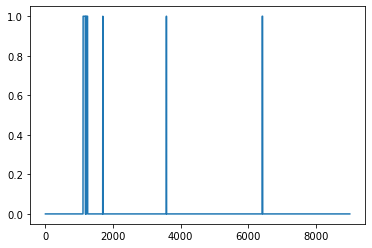

Odour3_Animal_1_distance 0       211.528364
1       227.110236
2       245.334392
3       251.641278
4       270.516077
           ...    
8995    141.586304
8996    141.586304
8997    141.586304
8998    141.586304
8999    141.530764
Name: Odour3_Animal_1_distance, Length: 9000, dtype: float64


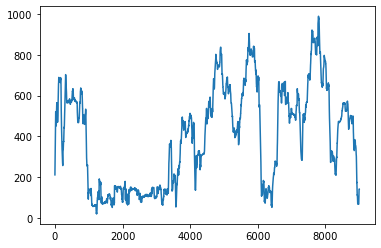

Odour3_Animal_1_facing 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour3_Animal_1_facing, Length: 9000, dtype: int64


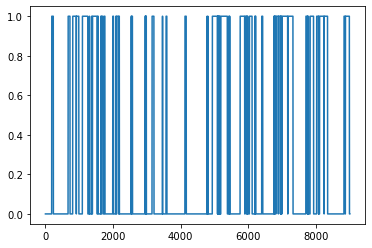

Odour5_Animal_1_in_zone 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour5_Animal_1_in_zone, Length: 9000, dtype: int64


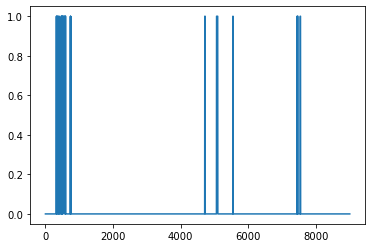

Odour5_Animal_1_distance 0       484.152100
1       473.025044
2       460.394389
3       454.992954
4       438.000775
           ...    
8995    567.208340
8996    567.208340
8997    567.208340
8998    567.208340
8999    568.477520
Name: Odour5_Animal_1_distance, Length: 9000, dtype: float64


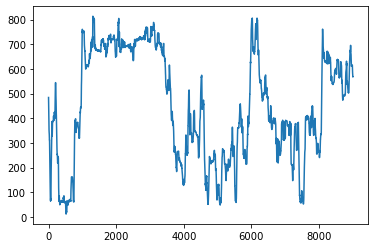

Odour5_Animal_1_facing 0       1
1       1
2       1
3       1
4       1
       ..
8995    1
8996    1
8997    1
8998    1
8999    1
Name: Odour5_Animal_1_facing, Length: 9000, dtype: int64


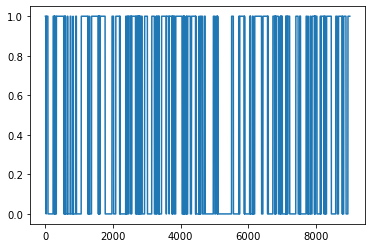

Odour2_Animal_1_in_zone 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour2_Animal_1_in_zone, Length: 9000, dtype: int64


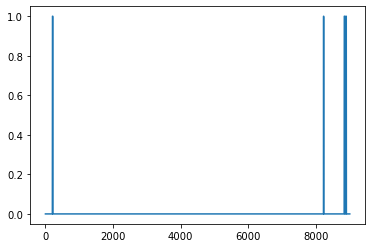

Odour2_Animal_1_distance 0       406.949483
1       415.817192
2       426.675475
3       429.633930
4       438.000775
           ...    
8995    160.018999
8996    160.018999
8997    160.018999
8998    160.018999
8999    159.849675
Name: Odour2_Animal_1_distance, Length: 9000, dtype: float64


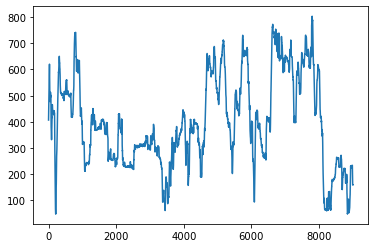

Odour2_Animal_1_facing 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour2_Animal_1_facing, Length: 9000, dtype: int64


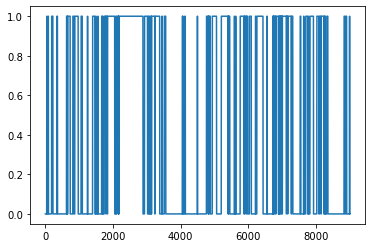

Odour4_Animal_1_in_zone_cumulative_time 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    9.533333
8996    9.533333
8997    9.533333
8998    9.533333
8999    9.533333
Name: Odour4_Animal_1_in_zone_cumulative_time, Length: 9000, dtype: float64


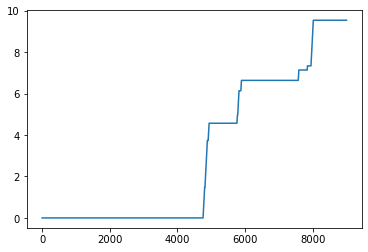

Odour4_Animal_1_in_zone_cumulative_percent 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    0.001060
8996    0.001060
8997    0.001060
8998    0.001059
8999    0.001059
Name: Odour4_Animal_1_in_zone_cumulative_percent, Length: 9000, dtype: float64


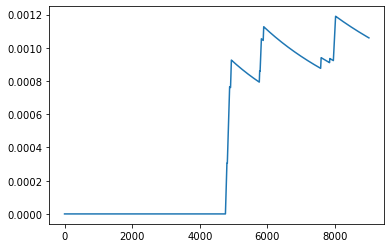

Odour6_Animal_1_in_zone_cumulative_time 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    6.666667
8996    6.666667
8997    6.666667
8998    6.666667
8999    6.666667
Name: Odour6_Animal_1_in_zone_cumulative_time, Length: 9000, dtype: float64


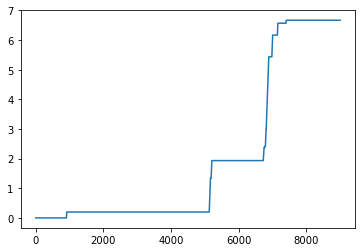

Odour6_Animal_1_in_zone_cumulative_percent 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    0.000741
8996    0.000741
8997    0.000741
8998    0.000741
8999    0.000741
Name: Odour6_Animal_1_in_zone_cumulative_percent, Length: 9000, dtype: float64


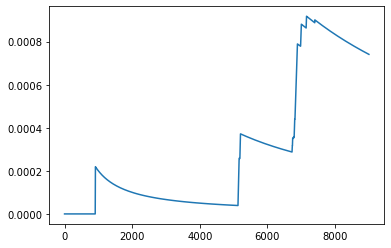

Odour1_Animal_1_in_zone_cumulative_time 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    7.666667
8996    7.666667
8997    7.666667
8998    7.666667
8999    7.666667
Name: Odour1_Animal_1_in_zone_cumulative_time, Length: 9000, dtype: float64


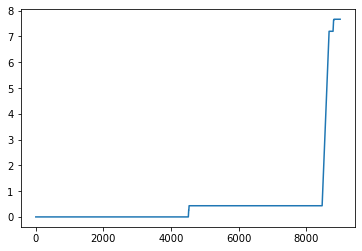

Odour1_Animal_1_in_zone_cumulative_percent 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    0.000852
8996    0.000852
8997    0.000852
8998    0.000852
8999    0.000852
Name: Odour1_Animal_1_in_zone_cumulative_percent, Length: 9000, dtype: float64


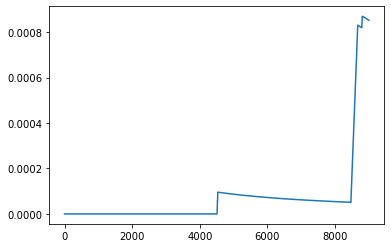

Odour3_Animal_1_in_zone_cumulative_time 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8995    4.3
8996    4.3
8997    4.3
8998    4.3
8999    4.3
Name: Odour3_Animal_1_in_zone_cumulative_time, Length: 9000, dtype: float64


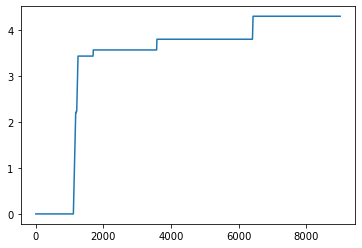

Odour3_Animal_1_in_zone_cumulative_percent 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    0.000478
8996    0.000478
8997    0.000478
8998    0.000478
8999    0.000478
Name: Odour3_Animal_1_in_zone_cumulative_percent, Length: 9000, dtype: float64


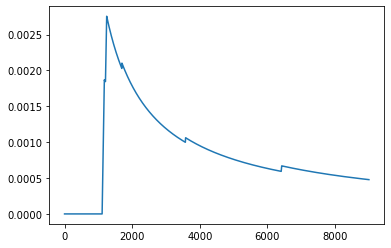

Odour5_Animal_1_in_zone_cumulative_time 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    8.266667
8996    8.266667
8997    8.266667
8998    8.266667
8999    8.266667
Name: Odour5_Animal_1_in_zone_cumulative_time, Length: 9000, dtype: float64


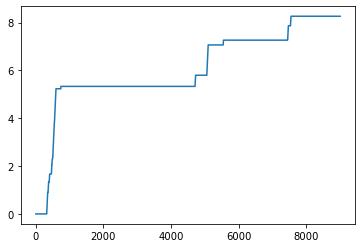

Odour5_Animal_1_in_zone_cumulative_percent 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    0.000919
8996    0.000919
8997    0.000919
8998    0.000919
8999    0.000919
Name: Odour5_Animal_1_in_zone_cumulative_percent, Length: 9000, dtype: float64


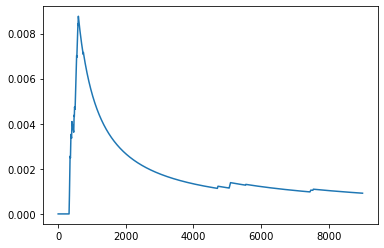

Odour2_Animal_1_in_zone_cumulative_time 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    1.566667
8996    1.566667
8997    1.566667
8998    1.566667
8999    1.566667
Name: Odour2_Animal_1_in_zone_cumulative_time, Length: 9000, dtype: float64


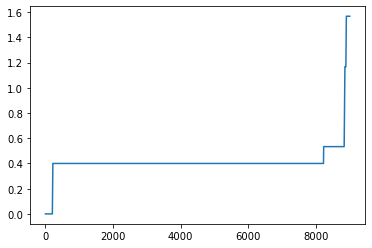

Odour2_Animal_1_in_zone_cumulative_percent 0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
8995    0.000174
8996    0.000174
8997    0.000174
8998    0.000174
8999    0.000174
Name: Odour2_Animal_1_in_zone_cumulative_percent, Length: 9000, dtype: float64


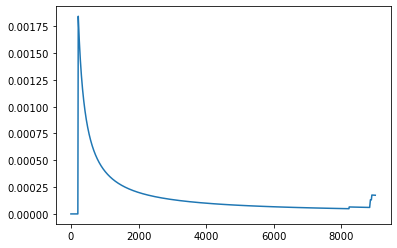

Odour1 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour1, Length: 9000, dtype: int64


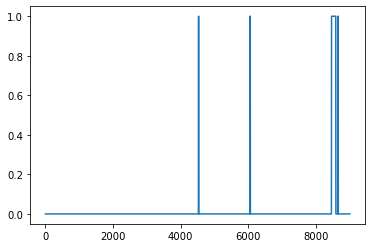

Odour2 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour2, Length: 9000, dtype: int64


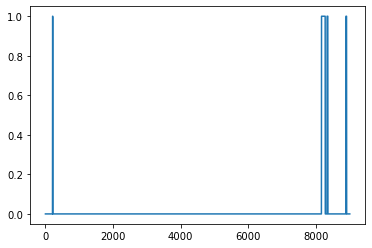

Odour3 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour3, Length: 9000, dtype: int64


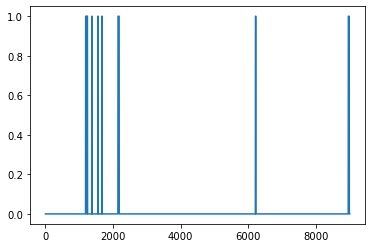

Odour4 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour4, Length: 9000, dtype: int64


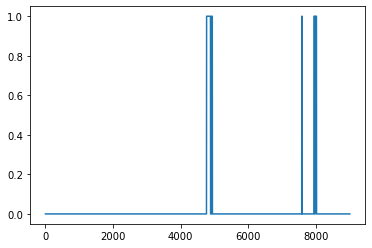

Odour5 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour5, Length: 9000, dtype: int64


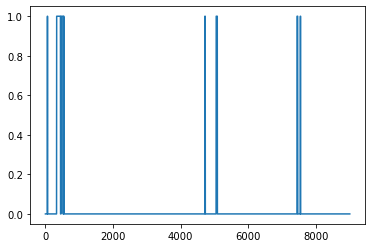

Odour6 0       0
1       0
2       0
3       0
4       0
       ..
8995    0
8996    0
8997    0
8998    0
8999    0
Name: Odour6, Length: 9000, dtype: int64


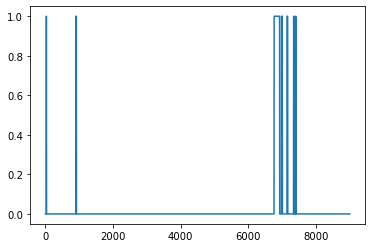

In [43]:
from matplotlib import pyplot as plt

for name, values in df_train.iteritems():
    print(name, values)
    plt.plot(df_train['Unnamed: 0'], values)
    plt.show()
# df.plot(figsize=(20,10))

Nose_movement_M1_sum_6


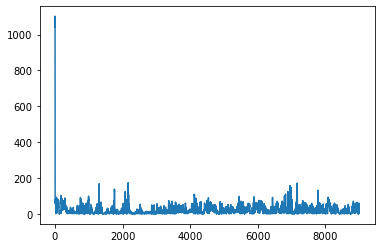

Odour3


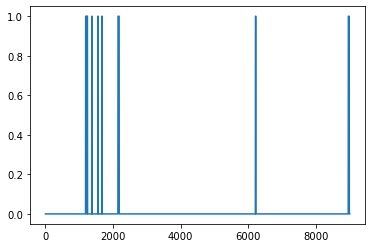

Odour3_Animal_1_distance


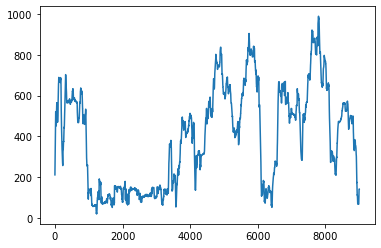

Odour3_Animal_1_facing


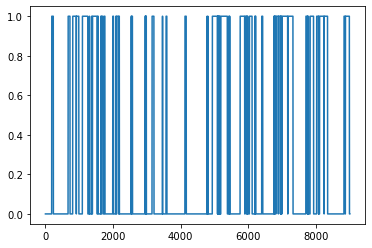

In [44]:
items = [
    (name, df_train[name])
    for name in [
        'Nose_movement_M1_sum_6', # See spike at beginning, most if not all derived metrics had this.
        # Fix: attempt cutting off the first few rows of the csv, after it has been created.
        'Odour3', # Binary, we can learn this from the distance.  This is what we want to know.
        'Odour3_Animal_1_distance',
        'Odour3_Animal_1_facing' # Don't think this will be useful
    ]    
]

for name, values in items:
    print(name)
    plt.plot(df_train['Unnamed: 0'], values)
    plt.show()


In [511]:
# Now, train a DTree
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.metrics import confusion_matrix, f1_score
from fnmatch import fnmatch

In [512]:
odour_features = [
    f for f in df_train.columns
    if fnmatch(f, '*Odour*')
]

prob_features = [
    f for f in df_train.columns
    if fnmatch(f, '*prob*')
]

non_odour_non_prob_features = sorted(set(df_train.columns) - set(odour_features + prob_features))
print(len(df_train.columns), len(odour_features), len(prob_features))
prob_features

282 36 7


['Sum_probabilities',
 'Sum_probabilities_deviation',
 'Sum_probabilities_deviation_percentile_rank',
 'Sum_probabilities_percentile_rank',
 'Low_prob_detections_0.1',
 'Low_prob_detections_0.5',
 'Low_prob_detections_0.75']

In [513]:
# Make sure the y_feature is present in each, actually lets take the most prevalent y_feature
y_features = [f'Odour{i}' for i in range(1,7)]
y_train_prevalence = [df_train[name].sum() for name in y_features]
y_test_prevalence = [df_test[name].sum() for name in y_features]
print(list(zip(y_features, y_train_prevalence)))
print(list(zip(y_features, y_test_prevalence)))

[('Odour1', 162), ('Odour2', 163), ('Odour3', 156), ('Odour4', 214), ('Odour5', 268), ('Odour6', 252)]
[('Odour1', 477), ('Odour2', 212), ('Odour3', 314), ('Odour4', 229), ('Odour5', 271), ('Odour6', 304)]


In [516]:
def combine_odours(_df):
    odour1 = _df['Odour1'] * 1
    odour2 = _df['Odour2'] * 2
    odour3 = _df['Odour3'] * 3
    odour4 = _df['Odour4'] * 4
    odour5 = _df['Odour5'] * 5
    odour6 = _df['Odour6'] * 6

    assert not any((odour1 > 0) & (odour2 > 0) & (odour3 > 0) & (odour4 > 0) & (odour5 > 0) & (odour6 > 0))
    
    combined = odour1 + odour2 + odour3 + odour4 + odour5 + odour6
    combined_df = pd.DataFrame(combined, columns=['combined_odours'])
    return combined_df


In [734]:
def train_dt(y_index, combine=False):
    y_feature = y_features[y_index]
    distance_feature = f'{y_feature}_Animal_1_distance'
    
    X_features = [distance_feature]
#     X_features = sorted(set(df_train.columns) - set([y_feature]))
#     X_features = non_odour_non_prob_features + [distance_feature]

    X_train = df_train[X_features]
    X_test = df_test[X_features]

    if combine:
        y_train = combine_odours(df_train)
        y_test = combine_odours(df_test)
    else:
        y_test = df_test[[y_feature]]
        y_train = df_train[[y_feature]]
        
    # TODO: Over sampling, under sampling...

    dt = DTree(
        criterion='entropy', # Gini is standard, shouldn't be a huge factor
        min_samples_leaf=2,
        max_features='sqrt',
        max_depth=5, # LIMIT MAX DEPTH!!  Runtime AND generalization error should improve drastically
    ).fit(X_train, y_train)
    return dt, X_test, y_test

In [735]:
_dts = [train_dt(0, combine=True)]

print([f1_score(y_test, dt.predict(X_test), average='macro') for dt, X_test, y_test in _dts])
[confusion_matrix(y_test, dt.predict(X_test)) for dt, X_test, y_test in _dts]

[0.321845220295328]


[array([[6716,  145,  173,    0,    0,    0,  159],
        [ 141,  336,    0,    0,    0,    0,    0],
        [ 111,    0,  101,    0,    0,    0,    0],
        [ 314,    0,    0,    0,    0,    0,    0],
        [ 229,    0,    0,    0,    0,    0,    0],
        [ 271,    0,    0,    0,    0,    0,    0],
        [ 237,    0,    0,    0,    0,    0,   67]])]

In [736]:
_dts = [train_dt(i) for i in range(6)]

print([f1_score(y_test, dt.predict(X_test), average='macro') for dt, X_test, y_test in _dts])
[confusion_matrix(y_test, dt.predict(X_test)) for dt, X_test, y_test in _dts]

[0.7482348165655539, 0.5591260899382776, 0.5684190133483205, 0.6815062996549233, 0.817251101016686, 0.7663263509945433]


[array([[8496,   27],
        [ 302,  175]]),
 array([[8670,  118],
        [ 188,   24]]),
 array([[8562,  124],
        [ 276,   38]]),
 array([[8669,  102],
        [ 152,   77]]),
 array([[8505,  224],
        [  33,  238]]),
 array([[8622,   74],
        [ 162,  142]])]

[Text(132.0121323529412, 201.90857142857143, 'X[0] <= 73.689\ngini = 0.249\nsamples = 9000\nvalue = [7785, 162, 163, 156, 214, 268, 252]'),
 Text(29.541176470588237, 170.84571428571428, 'X[0] <= 42.222\ngini = 0.492\nsamples = 335\nvalue = [146, 0, 0, 0, 0, 0, 189]'),
 Text(24.61764705882353, 139.78285714285715, 'gini = 0.0\nsamples = 71\nvalue = [0, 0, 0, 0, 0, 0, 71]'),
 Text(34.464705882352945, 139.78285714285715, 'X[0] <= 55.507\ngini = 0.494\nsamples = 264\nvalue = [146, 0, 0, 0, 0, 0, 118]'),
 Text(9.847058823529412, 108.72, 'X[0] <= 52.507\ngini = 0.251\nsamples = 34\nvalue = [29, 0, 0, 0, 0, 0, 5]'),
 Text(4.923529411764706, 77.65714285714284, 'gini = 0.0\nsamples = 11\nvalue = [11, 0, 0, 0, 0, 0, 0]'),
 Text(14.770588235294118, 77.65714285714284, 'X[0] <= 55.176\ngini = 0.34\nsamples = 23\nvalue = [18, 0, 0, 0, 0, 0, 5]'),
 Text(9.847058823529412, 46.59428571428572, 'X[0] <= 52.962\ngini = 0.486\nsamples = 12\nvalue = [7, 0, 0, 0, 0, 0, 5]'),
 Text(4.923529411764706, 15.531428

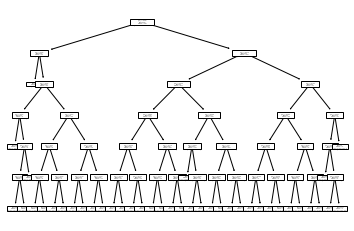

In [466]:
from sklearn import tree
tree.plot_tree(dt)

In [37]:
help(DTree)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best ran